In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
NUM_ITER = 1
k = 5000 #use for taking expectation in computing loss

In [3]:
torch.manual_seed(12345)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [4]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        if aptamer == "CTTTGTAATTGGTTCTGAGTTCCGTTGTGGGAGGAACATG": #took out aptamer control
            continue
        for peptide, _ in peptides:
            peptide = peptide.replace("_", "") #removed stop codons
            if "RRRRRR" in peptide: #took out peptide control
                continue
            if len(aptamer) == 40 and len(peptide) == 8: #making sure right length
                ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    S_new_train = S_new[:int(0.8*k)]
    S_new_test = S_new[int(0.8*k):]
    return S_new, S_new_train, S_new_test
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [5]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
S = construct_dataset()
n = len(S)
m = int(0.8*n) #length of S_train
S_train = S[:m]
S_test = S[m:]
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new, S_new_train, S_new_test = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

## NN Model

In [6]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.cnn_apt_1 = nn.Conv2d(1, 120, (4,4)) #similar to 4-gram
        self.cnn_pep_1 = nn.Conv2d(1, 50, (4,20))
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4690, 1)
        
    def forward(self, apt, pep):
        apt = self.cnn_apt_1(apt)
        apt = self.relu(apt)
        pep = self.cnn_pep_1(pep)
        pep = self.relu(pep)
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [7]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (1, 1, apt.shape[0], apt.shape[1]))).cuda() #(1, 1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (1, 1, pep.shape[0], pep.shape[1]))).cuda() #(1, 1, 8, 20)
    return apt, pep

def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.cuda()
    y = y.cuda()
    out = model(x, y)
    return out

def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs
    
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = 2*m
    else:
        dset = prime_test_loss_samples
        leng = 2*(n-m)
    for (apt, pep, ind, pmf) in dset:
        x = apt.cuda()
        y = pep.cuda()
        out = model(x, y)
        out_is = out.cpu().detach().numpy().flatten()[0] * pmf * get_x_pmf() * leng * ind
        outs.append(out_is)
        res = np.average(outs)
    return res

def plot_loss(train_loss, test_loss, i, lamb, gamma):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.plot(test_loss, 'y', label='Test loss')
    plt.title('Loss after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

def plot_recall(train_recall, test_recall, i, lamb, gamma):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.title('Recall after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()
    
def plot_cdf(train_cdf, test_cdf, i, lamb, gamma):
    plt.plot(train_cdf, 'b', label='Train CDF')
    plt.plot(test_cdf, 'y', label='Test CDF')
    plt.title('CDF after ' + str(i) + " iterations, " + 'lambda =%.5f' % lamb  + ' gamma =%.5f' % gamma)
    plt.legend()
    plt.show()

In [8]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [9]:
def sgd(lamb=1e28, #hyperparam
        gamma=1e-3): #step size
    
    optim = SGD(model.parameters(), lr=gamma)

    train_losses = []
    train_recalls = []
    train_recall_outputs = [] 

    test_losses = []
    test_recalls = []
    test_recall_outputs = []

    new_outputs = []
    
    train_correct = 0
    test_correct = 0
    
    for i, ele in enumerate(tqdm.tqdm(train_ds)):
        if i == 0:
            continue
        model.train()
        optim.zero_grad() #reset gradients after update
        x, y = convert(ele[0], ele[1]) #sample x,y from S_train
        out = update(x, y) #get S_train output/score
        log_out = torch.log(out) #take log
        # Calculate train recall
        train_score = out.cpu().detach().numpy().flatten()[0] #get score in float
        if train_score > 0.6:
            train_correct += 1 #contribute to train recall
        train_recall_outputs.append(train_score) #store the train scores
        
        optim.zero_grad() #reset gradients for the second branch
        y_pmf = get_y_pmf(ele[2][1])
        x_prime, y_prime = convert(ele[2][0], ele[2][1]) #sample x', y' from S_prime_train
        out_prime = update(x_prime, y_prime) #get score'
        out_prime = out_prime*y_pmf*get_x_pmf()*2*m #adjust for IS
        const = ele[3] #indicator
        (lamb*const*out_prime - log_out).backward(retain_graph=True) #backprop
        optim.step() #gradient update

        model.eval()
        x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
        test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0] #get test score in float
        test_recall_outputs.append(test_score) #store the test scores
        if test_score > 0.6:
            test_correct += 1 #contribute to test recall
            
        #generate 10 unseen examples from S_new as compared 1 example from validate/train for cdfs
        for x, y in S_new[10*i:10*(i+1)]:
            x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
            new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
            new_outputs.append(new_score) #store the new unknown scores

        if i % 500 == 0:
            train_loss = lamb*get_out_prime("train") - get_log_out('train') #training loss
            test_loss = (m/(n-m))*lamb*get_out_prime("test") - get_log_out('test') #test loss
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            train_recall = 100*train_correct/i #training recall
            train_recalls.append(train_recall) 
            test_recall = 100*test_correct/i #test recall
            test_recalls.append(test_recall)
            if i > 1000:
                train_score = np.asarray(new_outputs[-10000:] + train_recall_outputs[-1000:]) 
                test_score = np.asarray(new_outputs[-10000:] + test_recall_outputs[-1000:])
            else:
                train_score = np.asarray(new_outputs + train_recall_outputs) #combine train and unknown scores
                test_score = np.asarray(new_outputs + test_recall_outputs) #combibne test and unknown scores
            train_cdf = np.cumsum(train_score)/np.sum(train_score) #train cdf
            test_cdf = np.cumsum(test_score)/np.sum(test_score) #test cdf


        if i % 5000 == 0:
            plot_recall(train_recalls, test_recalls, i, lamb, gamma)
            plot_loss(train_losses, test_losses, i, lamb, gamma)
            plot_cdf(train_cdf, test_cdf, i, lamb, gamma)
            print("New score: ", np.average(new_outputs[-20:]))
            print("Train score: ", np.average(train_score[-20:]))
            print("Test score: ", np.average(test_score[-20:]))

## Hyperparameter tuning

In [10]:
gammas = [1e-3]
lambdas = [5e28]

  1%|          | 4996/473047 [02:51<1:41:27, 76.89it/s]  

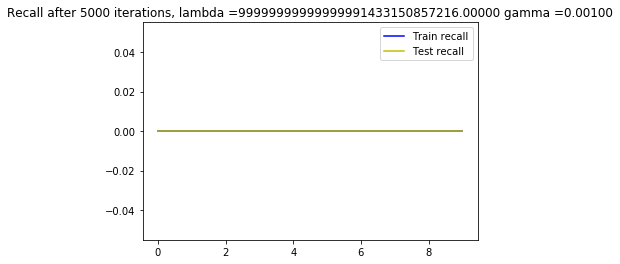

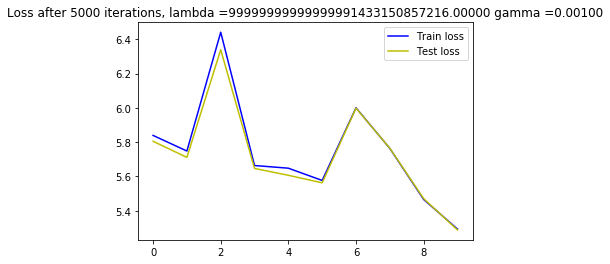

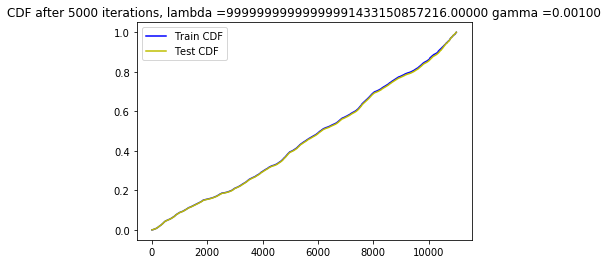

  1%|          | 5012/473047 [03:03<42:24:34,  3.07it/s]

New score:  0.01240365
Train score:  0.018131936
Test score:  0.013589675


  2%|▏         | 9993/473047 [05:52<1:40:16, 76.96it/s] 

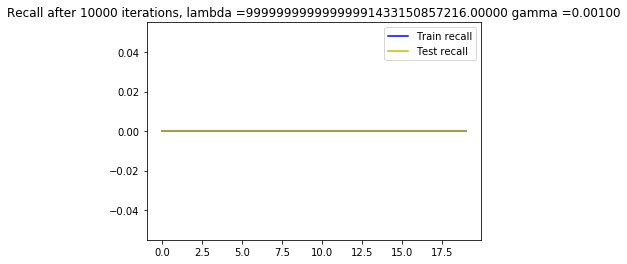

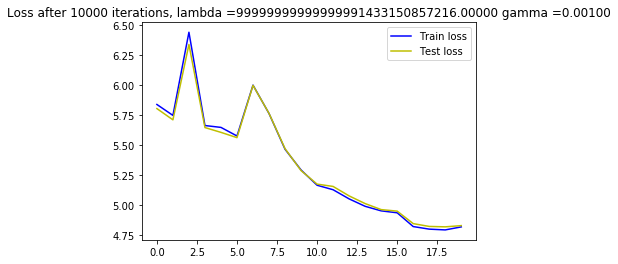

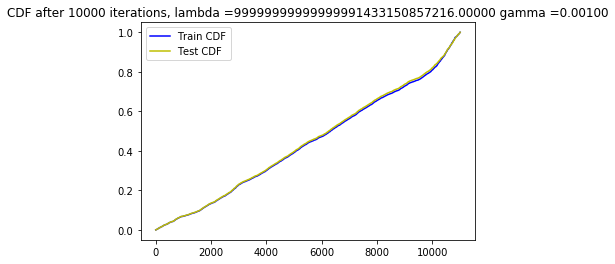

  2%|▏         | 10009/473047 [06:04<42:19:57,  3.04it/s]

New score:  0.0122476425
Train score:  0.05180023
Test score:  0.054221552


  3%|▎         | 15000/473047 [08:53<1:36:37, 79.01it/s]  

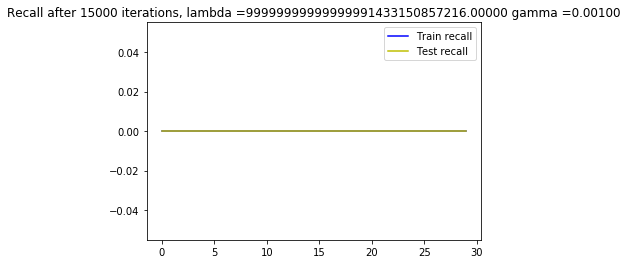

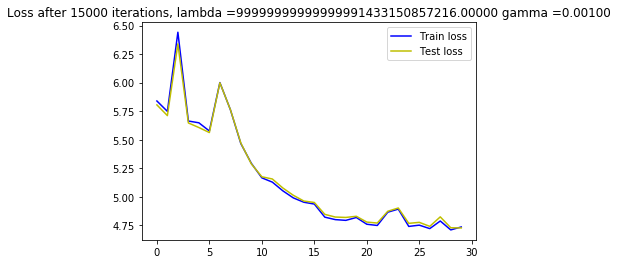

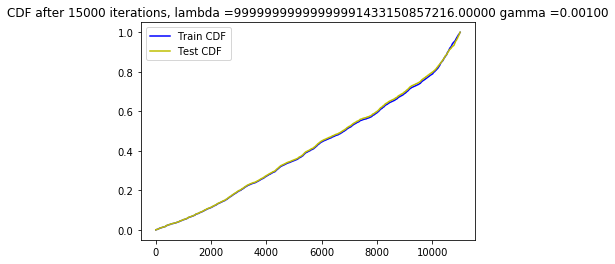

  3%|▎         | 15016/473047 [09:06<45:11:13,  2.82it/s]

New score:  0.013583933
Train score:  0.06222097
Test score:  0.0647742


  4%|▍         | 19999/473047 [11:55<1:37:00, 77.83it/s]  

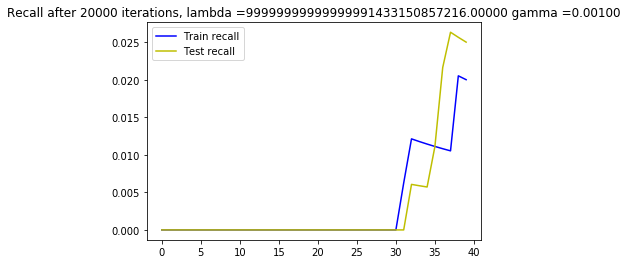

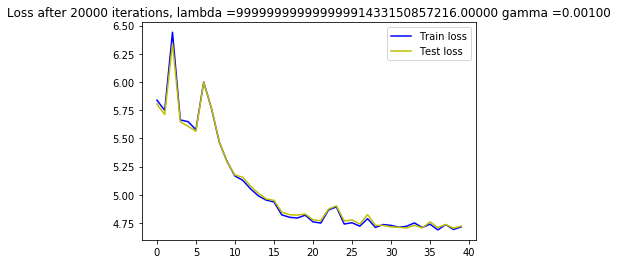

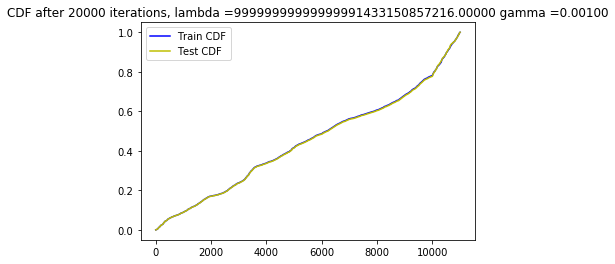

  4%|▍         | 20015/473047 [12:07<41:38:57,  3.02it/s]

New score:  0.024141792
Train score:  0.039162748
Test score:  0.041121695


  5%|▌         | 24995/473047 [14:56<1:36:38, 77.26it/s]  

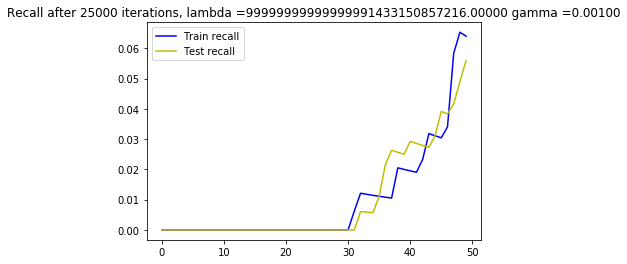

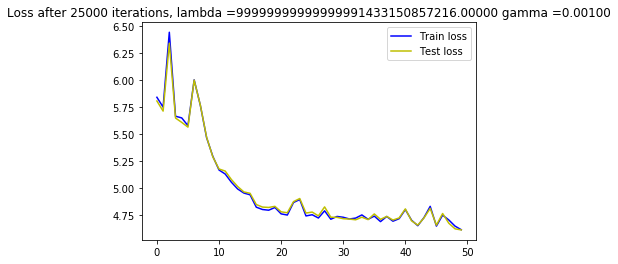

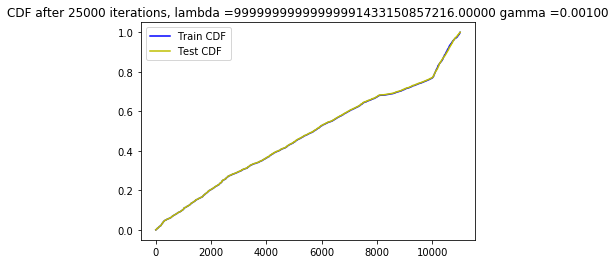

  5%|▌         | 25011/473047 [15:08<40:49:20,  3.05it/s]

New score:  0.018863015
Train score:  0.11422588
Test score:  0.05204016


  6%|▋         | 29994/473047 [17:57<1:39:20, 74.33it/s]  

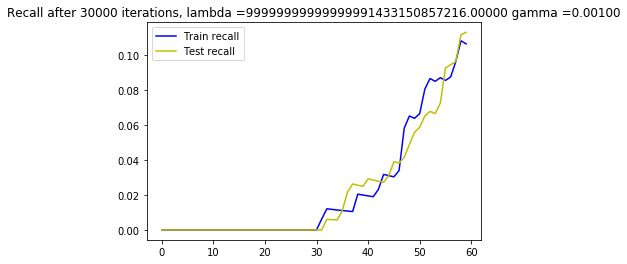

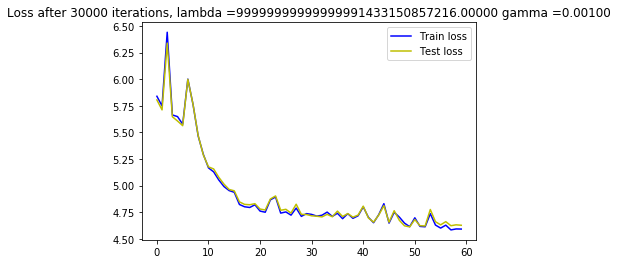

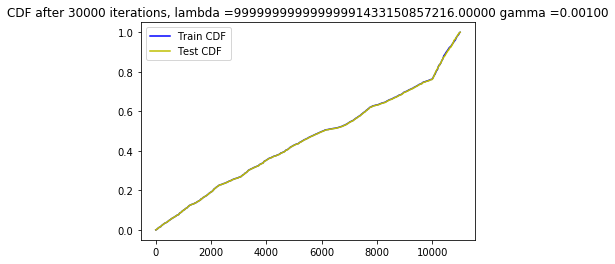

  6%|▋         | 30010/473047 [18:09<40:33:25,  3.03it/s]

New score:  0.045253426
Train score:  0.032974355
Test score:  0.03842081


  7%|▋         | 34996/473047 [21:01<1:34:11, 77.52it/s]  

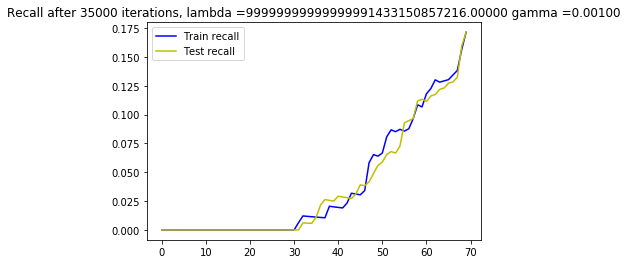

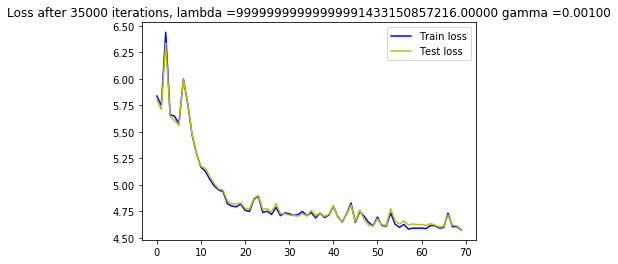

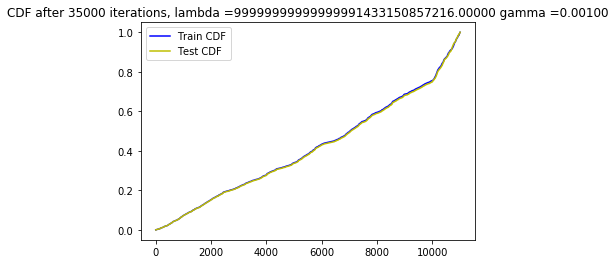

  7%|▋         | 35012/473047 [21:13<40:19:08,  3.02it/s]

New score:  0.025714707
Train score:  0.094638
Test score:  0.10646472


  8%|▊         | 40000/473047 [24:02<1:33:18, 77.36it/s]  

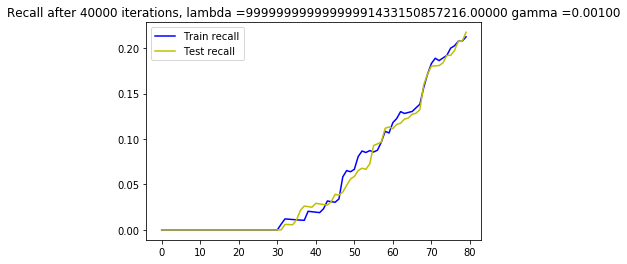

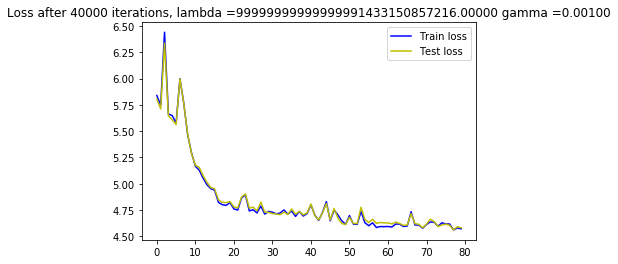

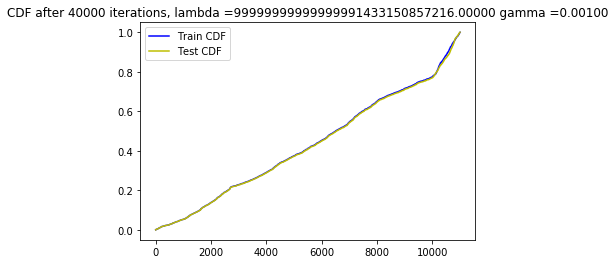

  8%|▊         | 40016/473047 [24:15<39:53:35,  3.02it/s]

New score:  0.009843502
Train score:  0.07338281
Test score:  0.054181196


 10%|▉         | 44993/473047 [27:04<1:38:04, 72.74it/s]  

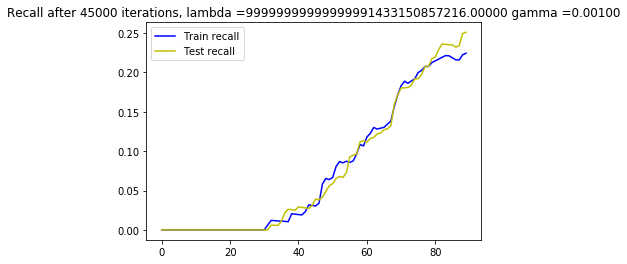

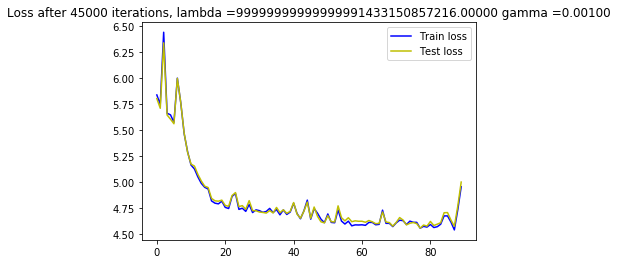

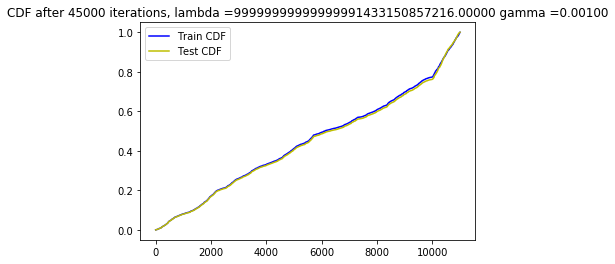

 10%|▉         | 45009/473047 [27:16<39:16:23,  3.03it/s]

New score:  0.009520775
Train score:  0.090161905
Test score:  0.024332073


 11%|█         | 49994/473047 [30:07<1:30:40, 77.76it/s] 

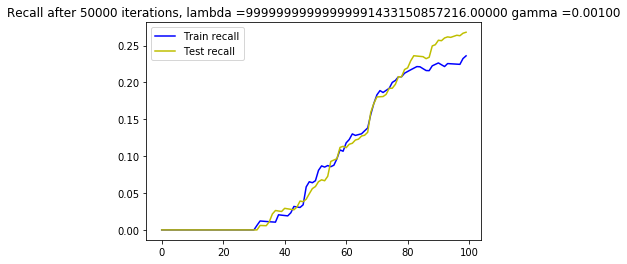

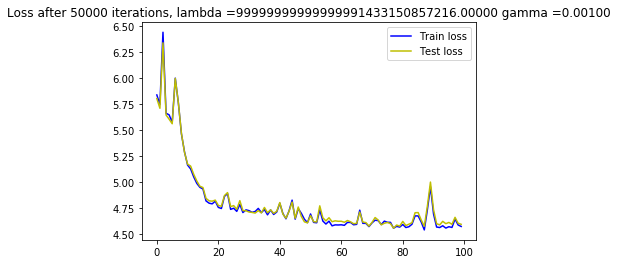

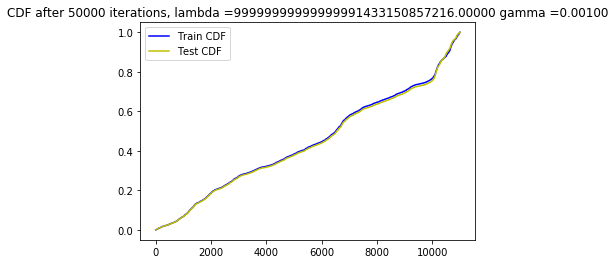

 11%|█         | 50010/473047 [30:20<38:51:19,  3.02it/s]

New score:  0.009146491
Train score:  0.044781167
Test score:  0.035497878


 12%|█▏        | 54993/473047 [33:20<1:28:10, 79.03it/s]  

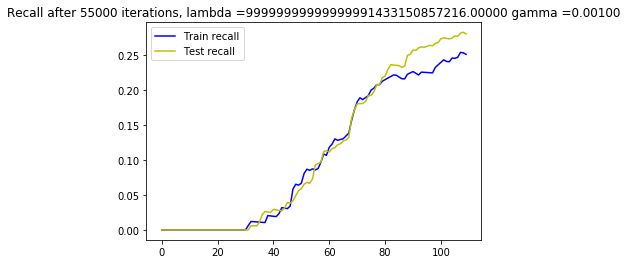

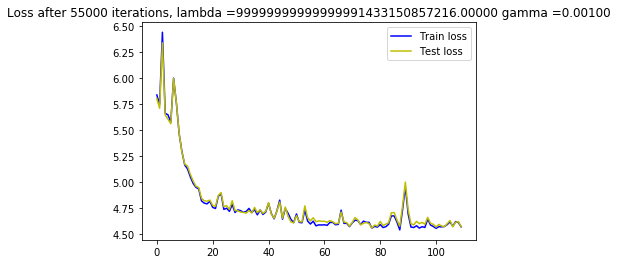

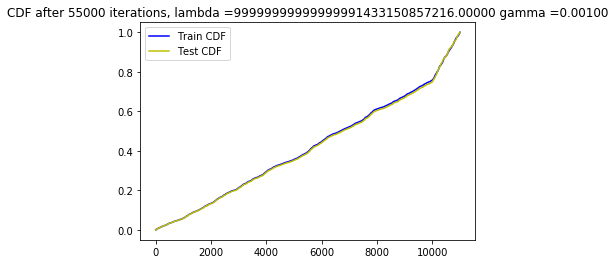

 12%|█▏        | 55009/473047 [33:21<38:04:39,  3.05it/s]

New score:  0.028657869
Train score:  0.054948427
Test score:  0.040357526


 13%|█▎        | 60000/473047 [36:10<1:30:03, 76.44it/s]  

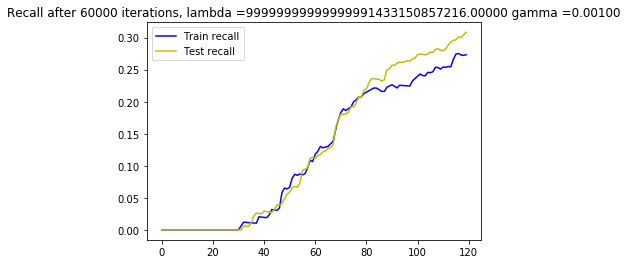

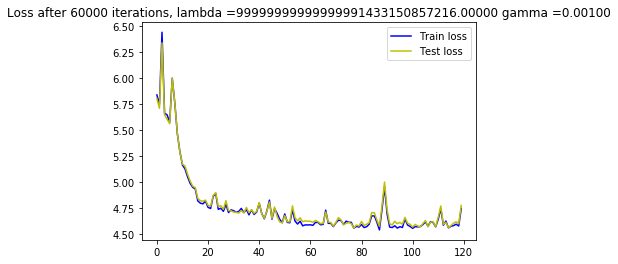

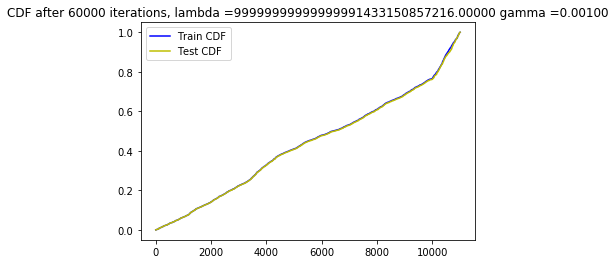

 13%|█▎        | 60016/473047 [36:22<37:50:30,  3.03it/s]

New score:  0.022281824
Train score:  0.032779943
Test score:  0.033146083


 14%|█▎        | 64996/473047 [39:11<1:27:50, 77.43it/s]  

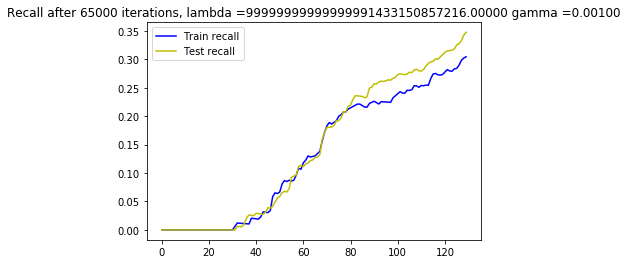

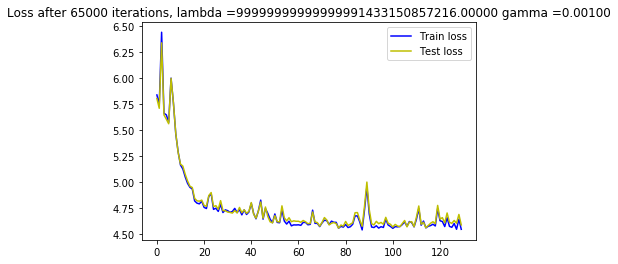

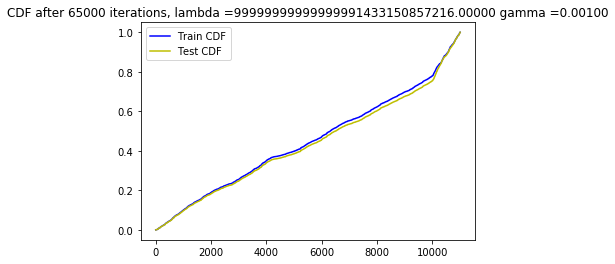

 14%|█▎        | 65012/473047 [39:23<37:01:00,  3.06it/s]

New score:  0.011231801
Train score:  0.044824388
Test score:  0.09742332


 15%|█▍        | 69994/473047 [42:10<1:23:43, 80.23it/s]  

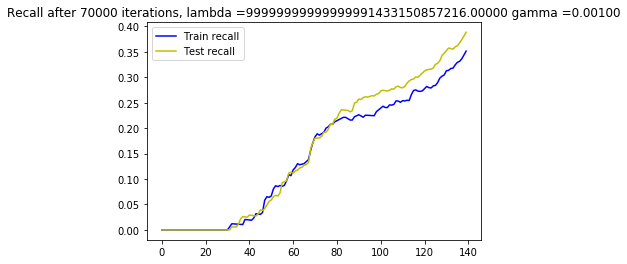

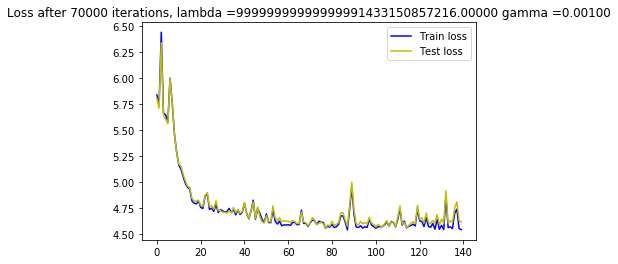

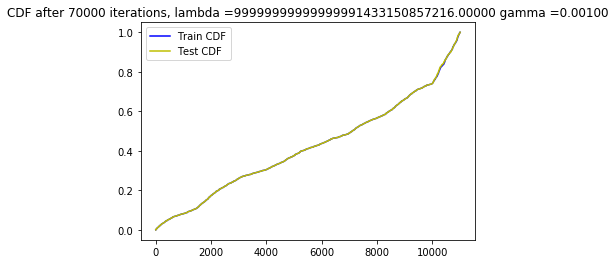

 15%|█▍        | 70012/473047 [42:22<32:33:45,  3.44it/s]

New score:  0.026697611
Train score:  0.05665242
Test score:  0.077821285


 16%|█▌        | 74993/473047 [45:20<1:23:04, 79.87it/s]  

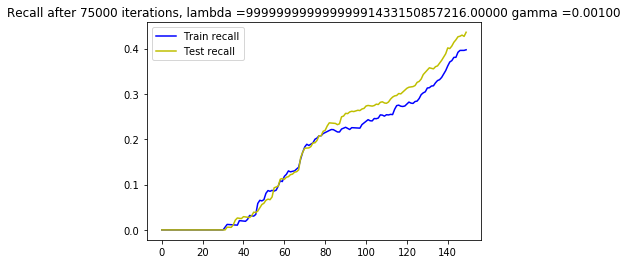

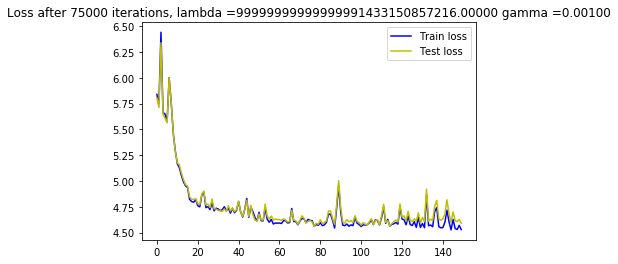

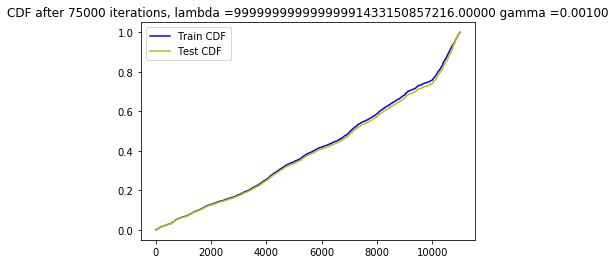

 16%|█▌        | 75009/473047 [45:21<36:25:00,  3.04it/s]

New score:  0.027139137
Train score:  0.04444692
Test score:  0.0584037


 17%|█▋        | 79993/473047 [48:12<1:28:32, 73.99it/s] 

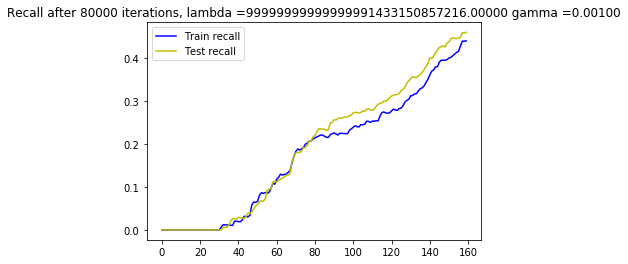

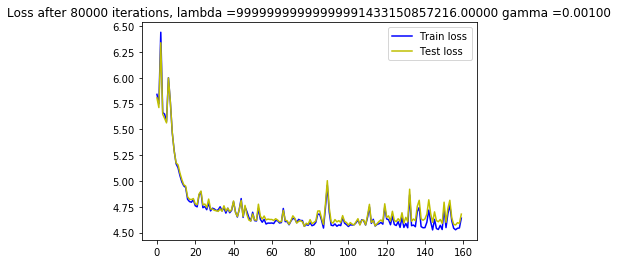

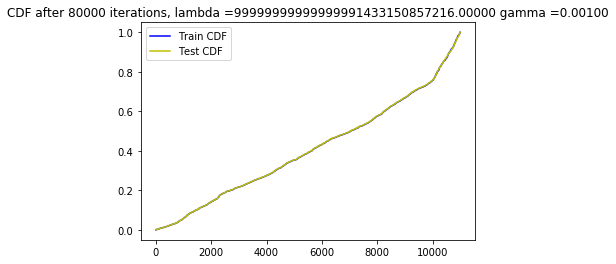

 17%|█▋        | 80009/473047 [48:24<36:09:43,  3.02it/s]

New score:  0.039593346
Train score:  0.0979177
Test score:  0.08357745


 18%|█▊        | 84997/473047 [51:17<1:28:34, 73.02it/s] 

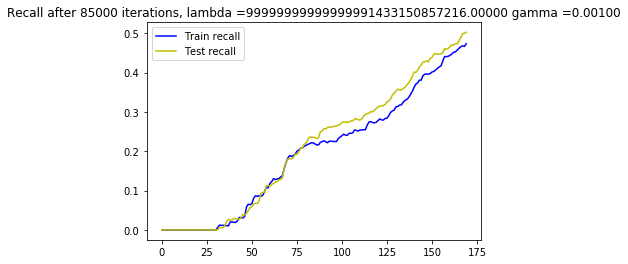

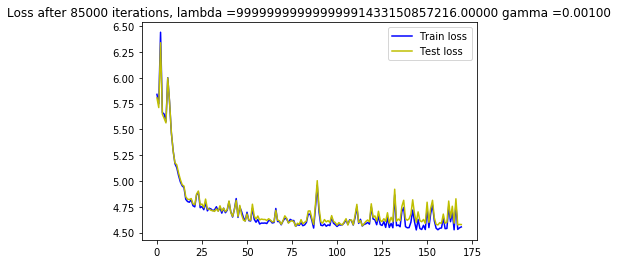

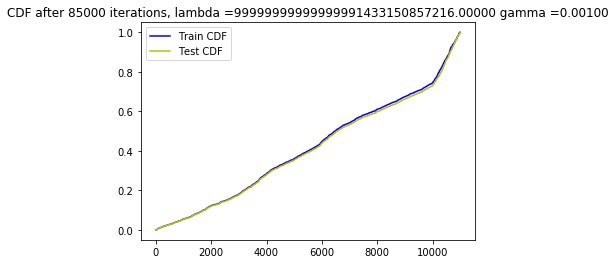

 18%|█▊        | 85013/473047 [51:29<35:52:59,  3.00it/s]

New score:  0.025480215
Train score:  0.03088424
Test score:  0.093149684


 19%|█▉        | 89993/473047 [54:22<1:24:41, 75.39it/s] 

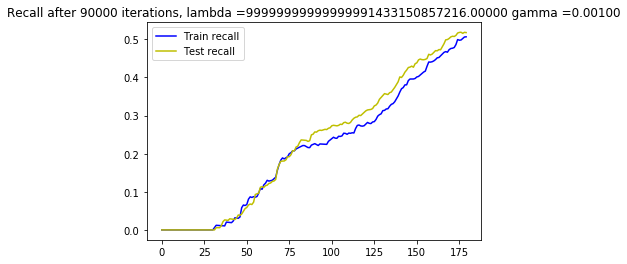

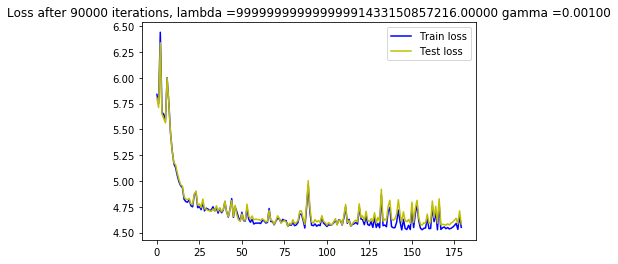

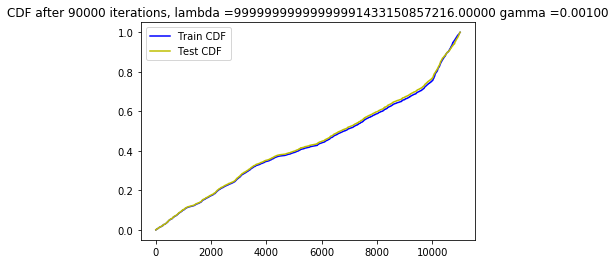

 19%|█▉        | 90010/473047 [54:34<35:09:43,  3.03it/s]

New score:  0.019095425
Train score:  0.043420024
Test score:  0.074748255


 20%|██        | 94996/473047 [57:23<1:25:37, 73.58it/s]  

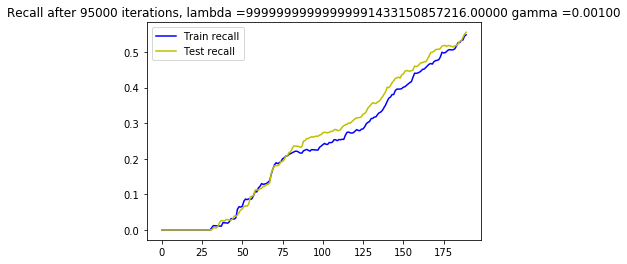

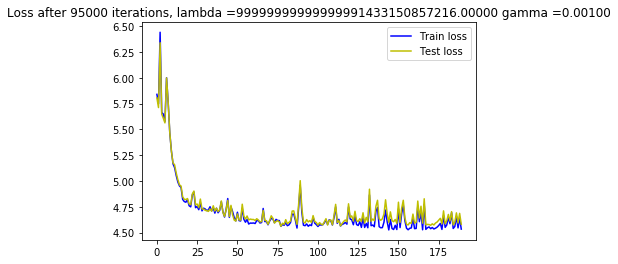

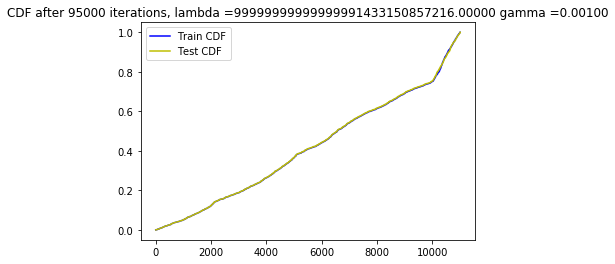

 20%|██        | 95012/473047 [57:35<35:05:59,  2.99it/s]

New score:  0.016092971
Train score:  0.07985451
Test score:  0.12102485


 21%|██        | 99996/473047 [1:00:31<1:29:45, 69.27it/s] 

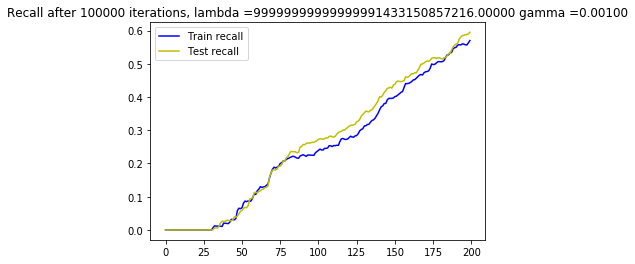

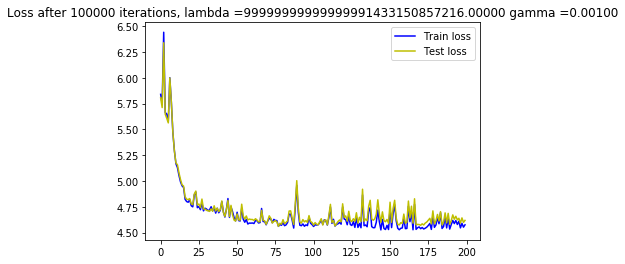

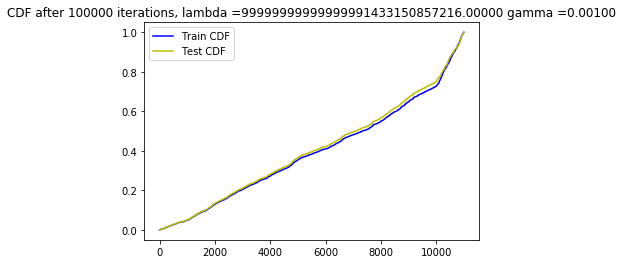

 21%|██        | 100011/473047 [1:00:44<39:42:35,  2.61it/s]

New score:  0.016968433
Train score:  0.045377437
Test score:  0.09942349


 22%|██▏       | 104995/473047 [1:03:50<1:24:19, 72.74it/s]  

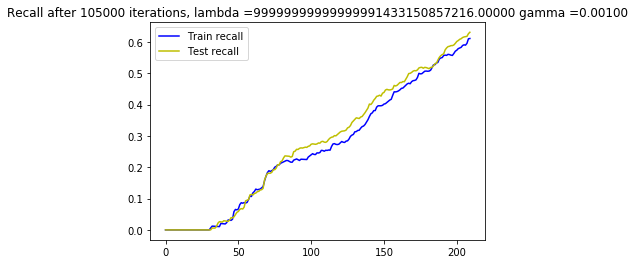

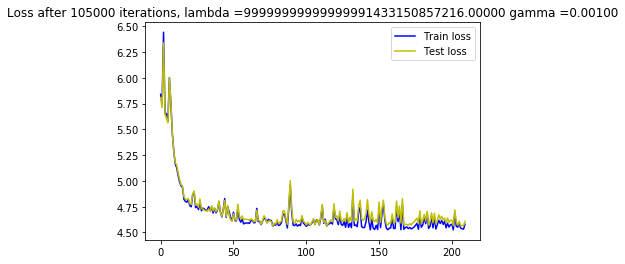

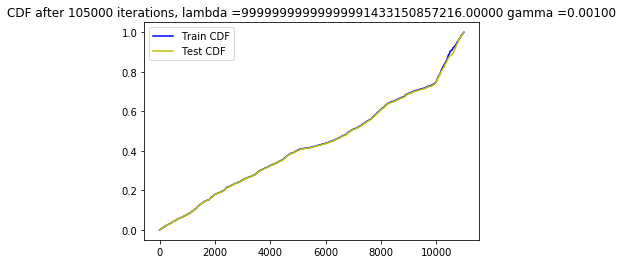

 22%|██▏       | 105009/473047 [1:03:51<44:46:27,  2.28it/s]

New score:  0.046206553
Train score:  0.04846393
Test score:  0.11246034


 23%|██▎       | 109995/473047 [1:06:46<1:24:38, 71.49it/s]  

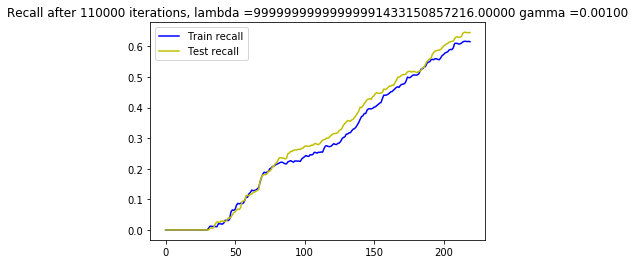

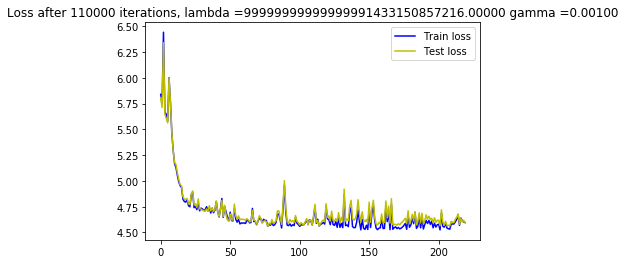

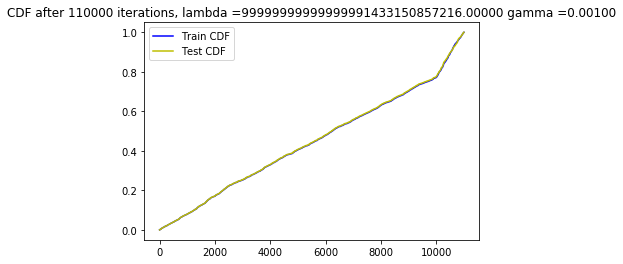

 23%|██▎       | 110011/473047 [1:06:58<32:58:39,  3.06it/s]

New score:  0.012691265
Train score:  0.051804252
Test score:  0.036847346


 24%|██▍       | 114997/473047 [1:09:51<1:21:29, 73.22it/s] 

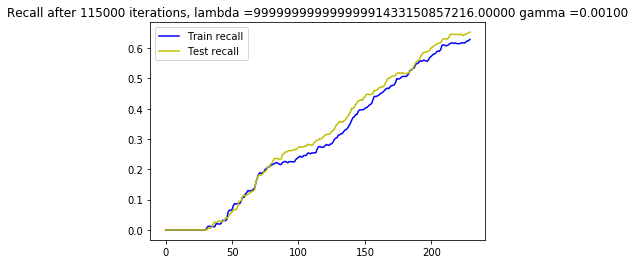

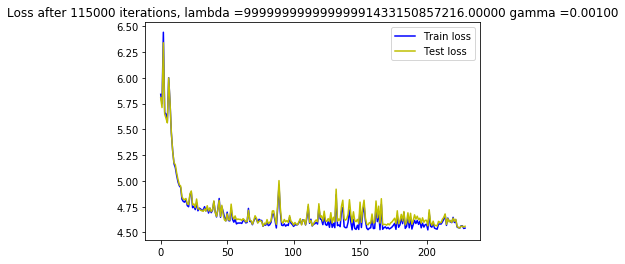

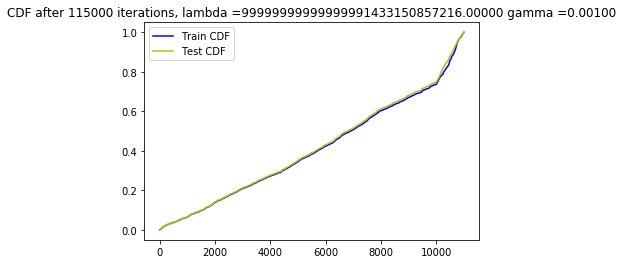

 24%|██▍       | 115013/473047 [1:10:03<33:12:24,  2.99it/s]

New score:  0.023516584
Train score:  0.06514977
Test score:  0.045558743


 25%|██▌       | 119999/473047 [1:13:00<1:09:31, 84.62it/s]  

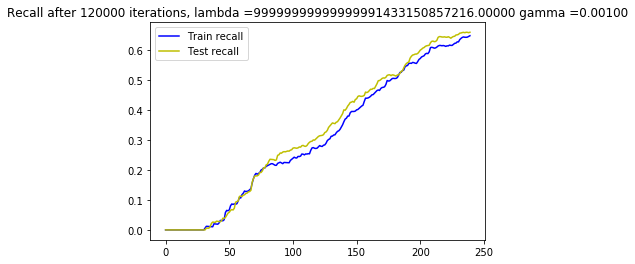

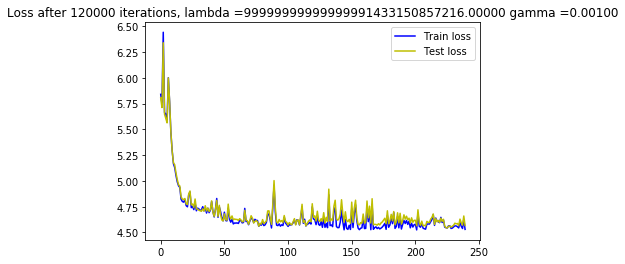

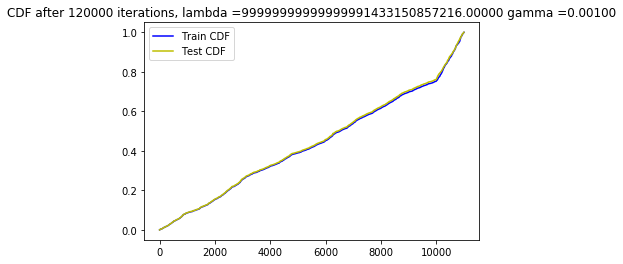

 25%|██▌       | 120010/473047 [1:13:01<124:05:51,  1.27s/it]

New score:  0.020184385
Train score:  0.067136034
Test score:  0.05773128


 26%|██▋       | 124999/473047 [1:15:45<1:10:58, 81.73it/s]  

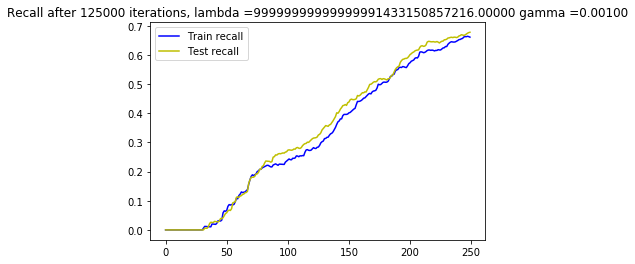

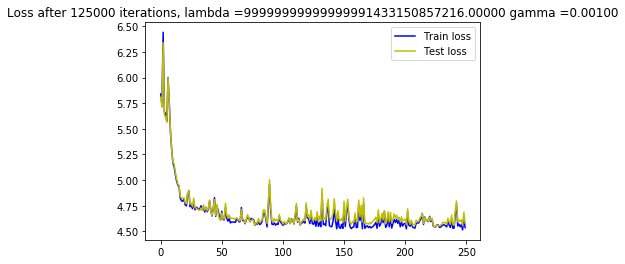

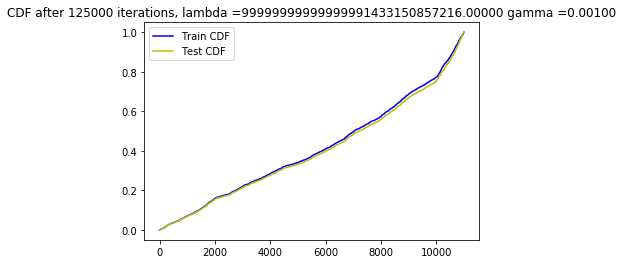

 26%|██▋       | 125017/473047 [1:15:58<28:06:06,  3.44it/s]

New score:  0.00988668
Train score:  0.08017575
Test score:  0.049535386


 27%|██▋       | 129995/473047 [1:18:42<1:08:44, 83.17it/s]  

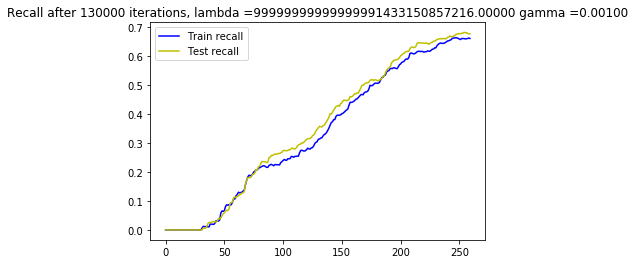

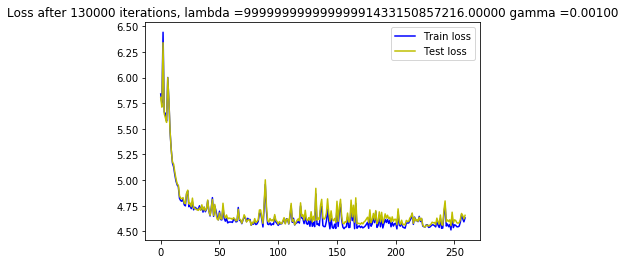

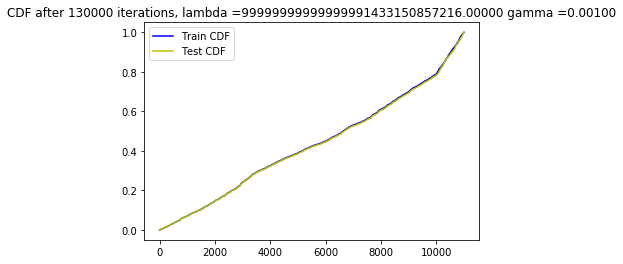

 27%|██▋       | 130013/473047 [1:18:54<27:51:01,  3.42it/s]

New score:  0.04023105
Train score:  0.06896263
Test score:  0.067854874


 29%|██▊       | 135000/473047 [1:21:37<1:08:41, 82.01it/s]  

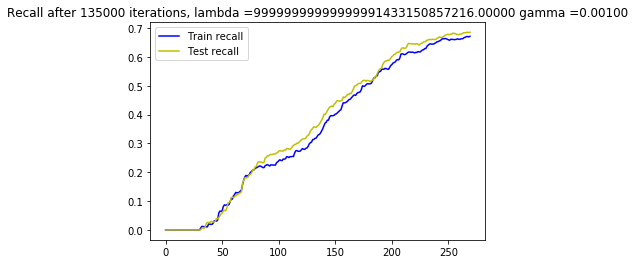

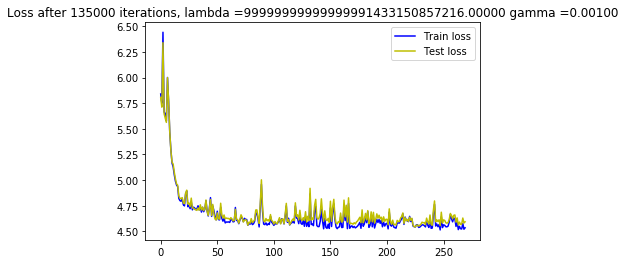

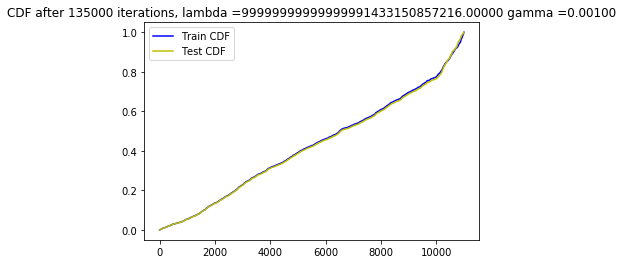

 29%|██▊       | 135009/473047 [1:21:50<38:31:48,  2.44it/s]

New score:  0.013042325
Train score:  0.13197748
Test score:  0.042813435


 30%|██▉       | 139996/473047 [1:24:35<1:15:04, 73.94it/s] 

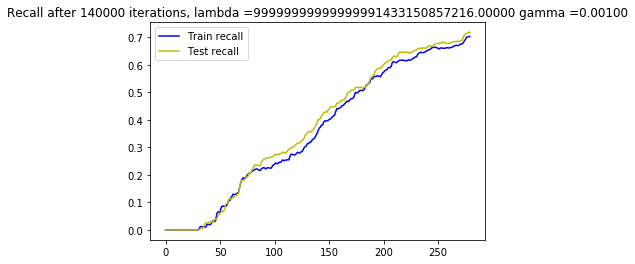

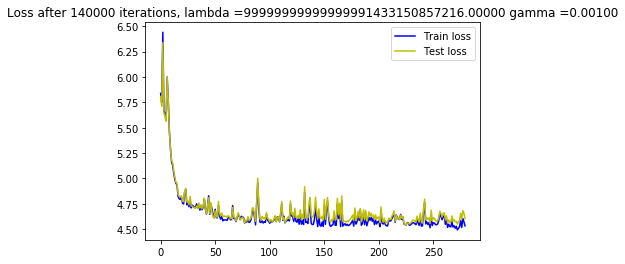

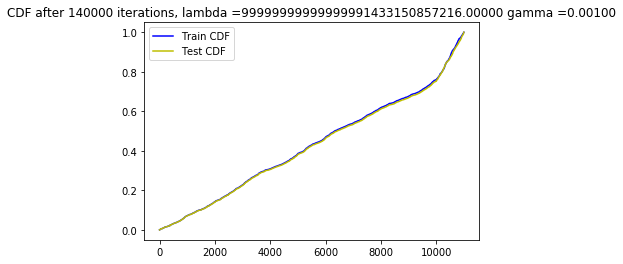

 30%|██▉       | 140012/473047 [1:24:47<30:31:34,  3.03it/s]

New score:  0.023030458
Train score:  0.07360405
Test score:  0.14598544


 31%|███       | 144993/473047 [1:27:50<1:14:31, 73.37it/s] 

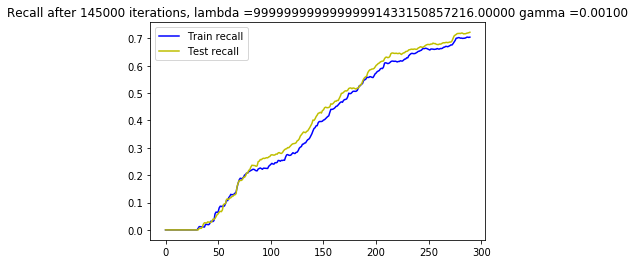

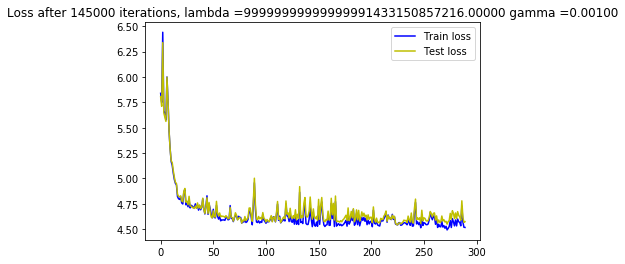

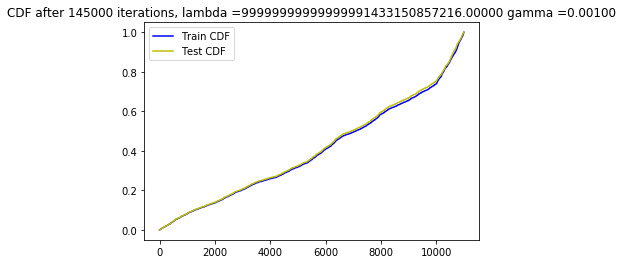

 31%|███       | 145009/473047 [1:27:51<29:54:30,  3.05it/s]

New score:  0.022698963
Train score:  0.15135802
Test score:  0.044494763


 32%|███▏      | 149993/473047 [1:30:42<1:12:21, 74.41it/s] 

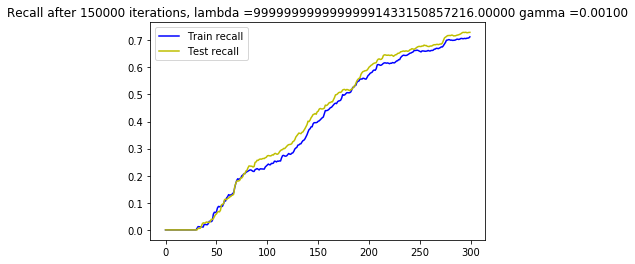

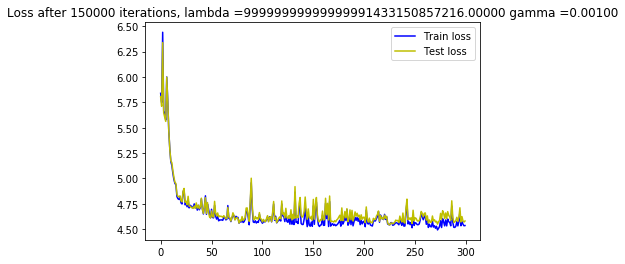

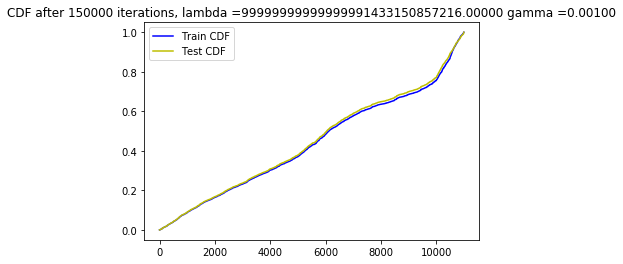

 32%|███▏      | 150009/473047 [1:30:54<29:21:49,  3.06it/s]

New score:  0.015155142
Train score:  0.077843845
Test score:  0.15626091


 33%|███▎      | 154993/473047 [1:33:46<1:10:08, 75.57it/s]  

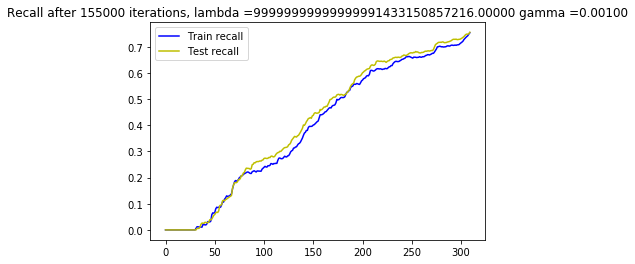

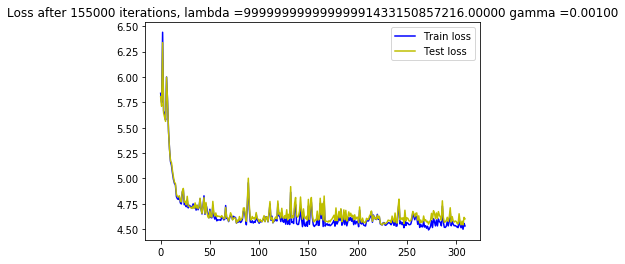

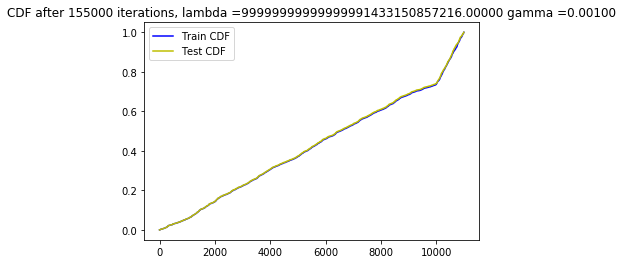

 33%|███▎      | 155009/473047 [1:33:58<28:50:11,  3.06it/s]

New score:  0.023772582
Train score:  0.1408526
Test score:  0.11875947


 34%|███▍      | 159997/473047 [1:36:51<1:10:52, 73.61it/s] 

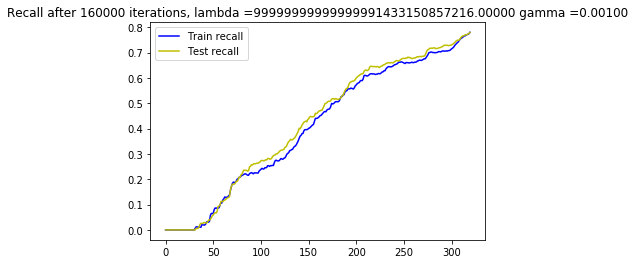

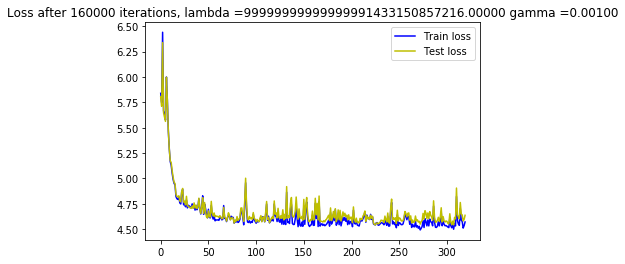

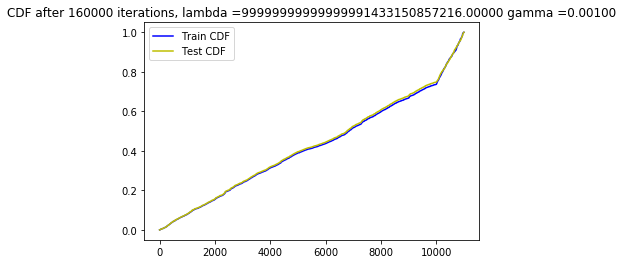

 34%|███▍      | 160013/473047 [1:37:03<29:11:17,  2.98it/s]

New score:  0.011542091
Train score:  0.054646123
Test score:  0.042737436


 35%|███▍      | 164993/473047 [1:40:10<1:10:24, 72.92it/s] 

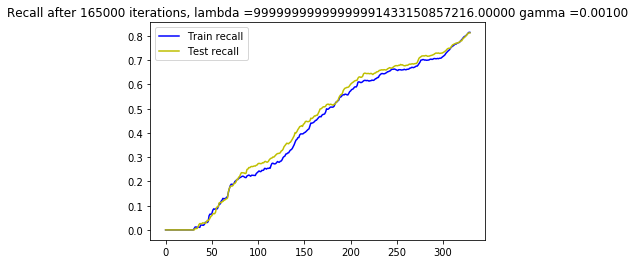

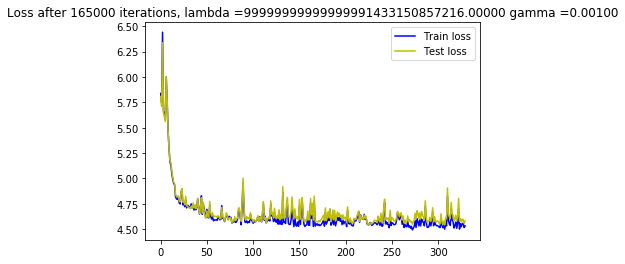

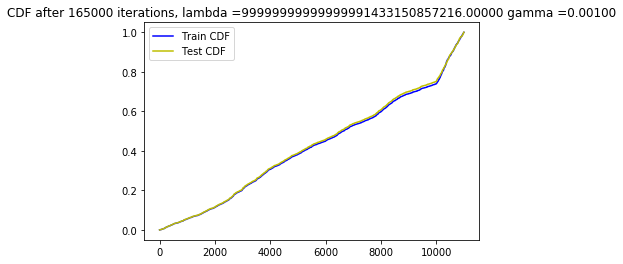

 35%|███▍      | 165009/473047 [1:40:11<28:46:53,  2.97it/s]

New score:  0.020428728
Train score:  0.07322169
Test score:  0.076143295


 36%|███▌      | 169996/473047 [1:43:11<1:14:54, 67.43it/s] 

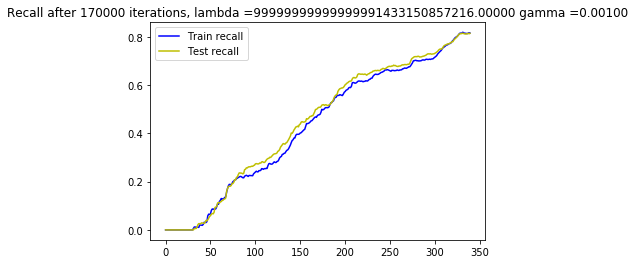

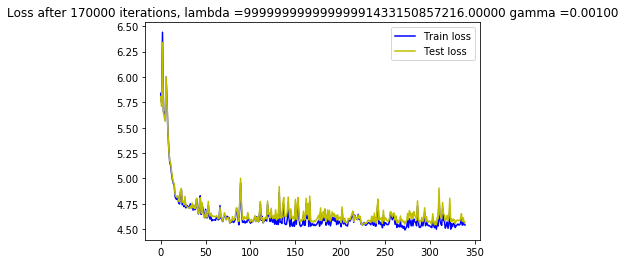

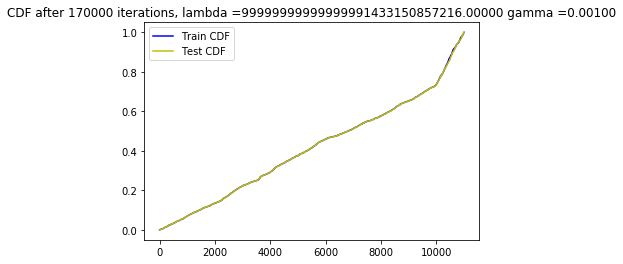

 36%|███▌      | 170011/473047 [1:43:23<31:58:28,  2.63it/s]

New score:  0.03995845
Train score:  0.11612616
Test score:  0.08942646


 37%|███▋      | 174993/473047 [1:46:15<1:06:50, 74.32it/s]  

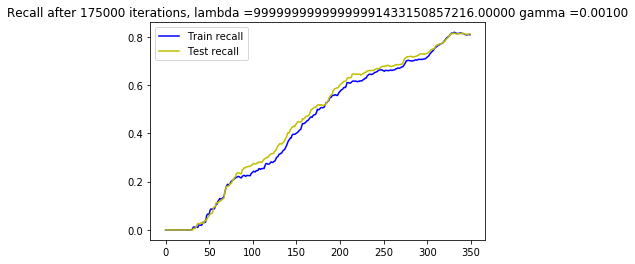

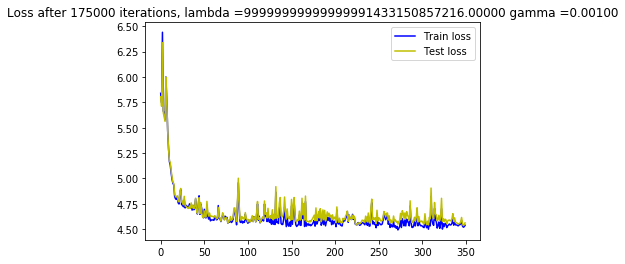

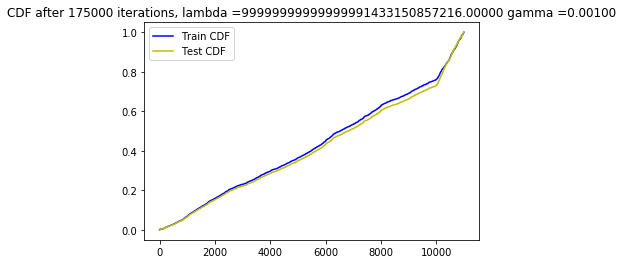

 37%|███▋      | 175009/473047 [1:46:28<27:39:26,  2.99it/s]

New score:  0.023025883
Train score:  0.08434123
Test score:  0.059351645


 38%|███▊      | 179997/473047 [1:49:20<1:05:36, 74.45it/s]  

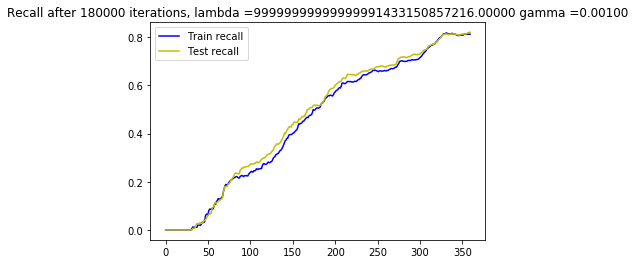

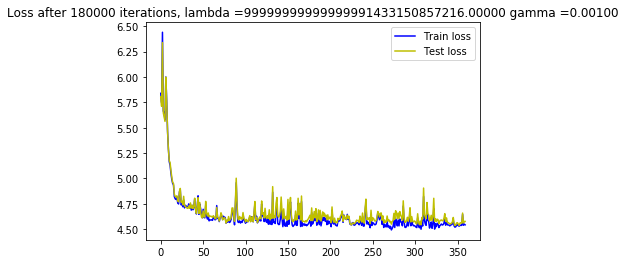

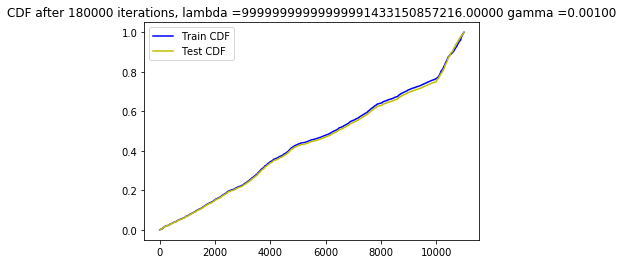

 38%|███▊      | 180013/473047 [1:49:33<27:06:48,  3.00it/s]

New score:  0.019698996
Train score:  0.05327183
Test score:  0.10033095


 39%|███▉      | 184995/473047 [1:52:25<1:05:17, 73.53it/s] 

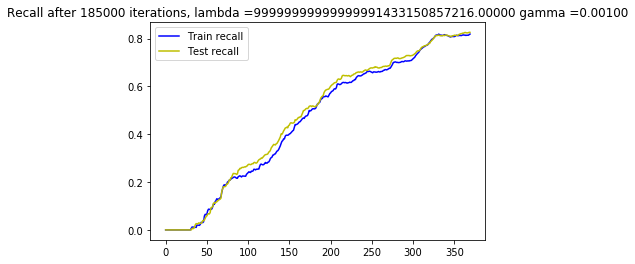

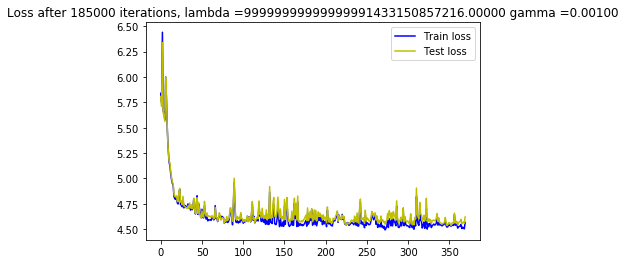

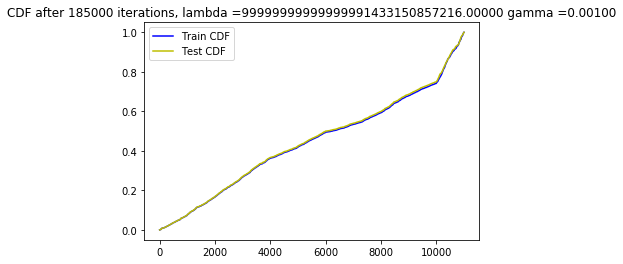

 39%|███▉      | 185011/473047 [1:52:37<26:53:14,  2.98it/s]

New score:  0.015126651
Train score:  0.08179376
Test score:  0.07618805


 40%|████      | 189996/473047 [1:55:31<59:39, 79.07it/s]   

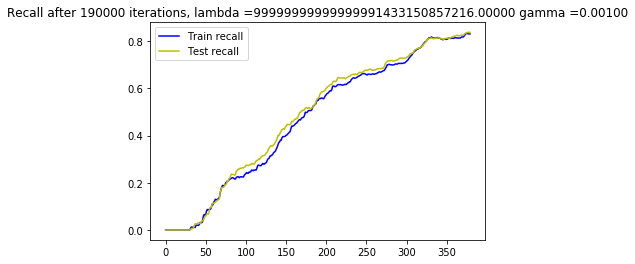

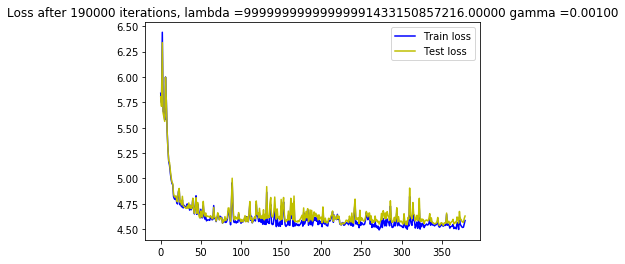

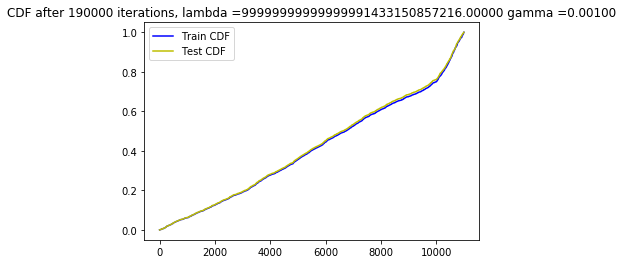

 40%|████      | 190012/473047 [1:55:43<25:53:56,  3.04it/s]

New score:  0.011791882
Train score:  0.11976937
Test score:  0.044803683


 41%|████      | 194993/473047 [1:58:35<1:03:45, 72.68it/s]  

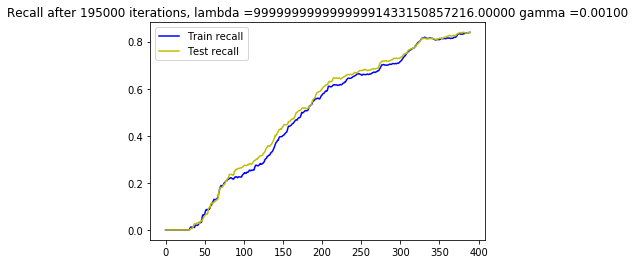

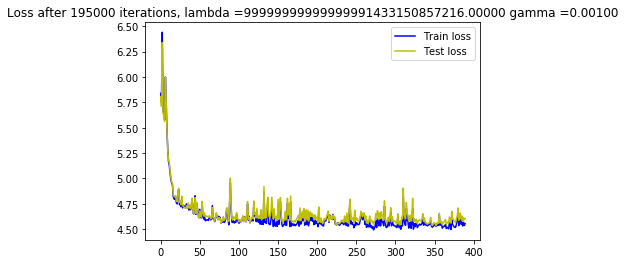

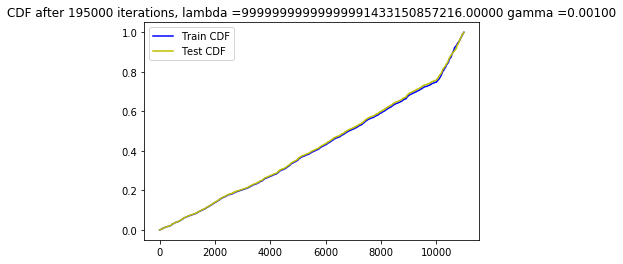

 41%|████      | 195009/473047 [1:58:48<25:21:43,  3.05it/s]

New score:  0.0044555664
Train score:  0.04406639
Test score:  0.070570536


 42%|████▏     | 199993/473047 [2:01:40<1:02:55, 72.32it/s] 

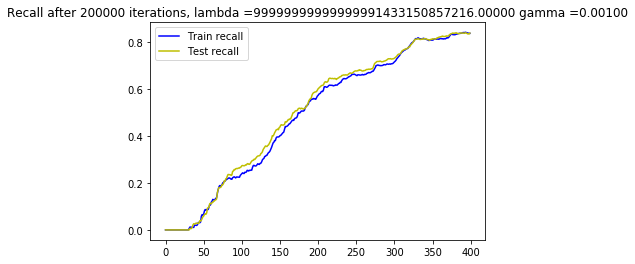

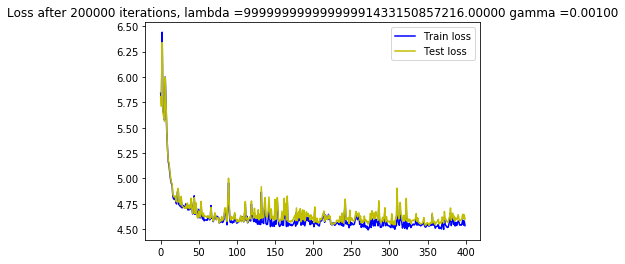

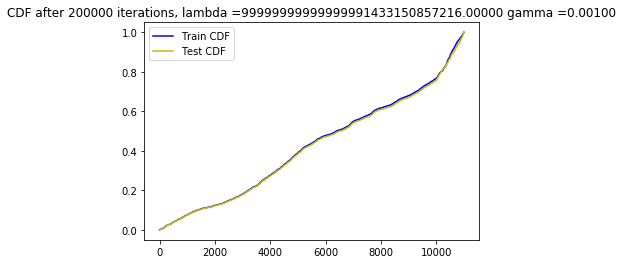

 42%|████▏     | 200009/473047 [2:01:52<25:00:25,  3.03it/s]

New score:  0.028431922
Train score:  0.08325694
Test score:  0.10460806


 43%|████▎     | 204997/473047 [2:04:45<1:01:14, 72.94it/s] 

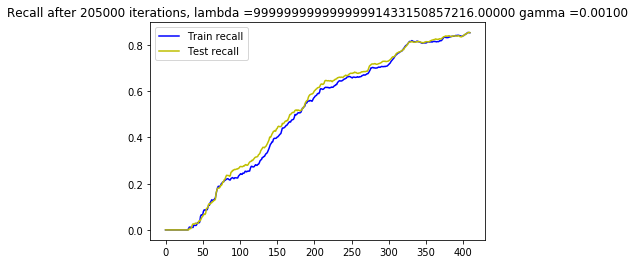

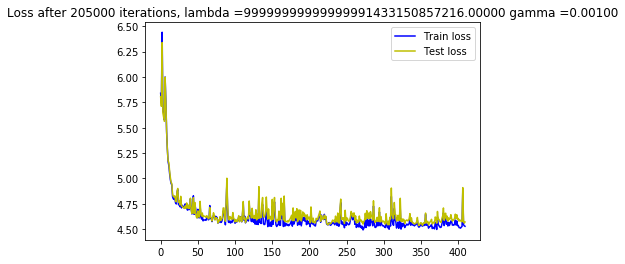

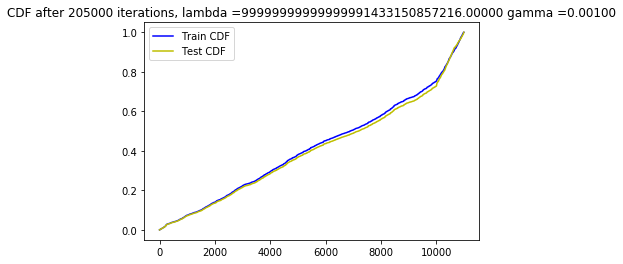

 43%|████▎     | 205013/473047 [2:04:58<27:11:03,  2.74it/s]

New score:  0.016214104
Train score:  0.036318637
Test score:  0.12445636


 44%|████▍     | 209996/473047 [2:08:00<58:33, 74.88it/s]   

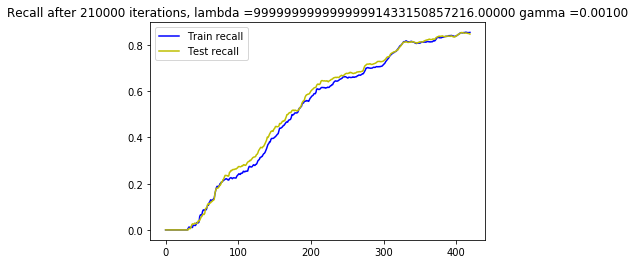

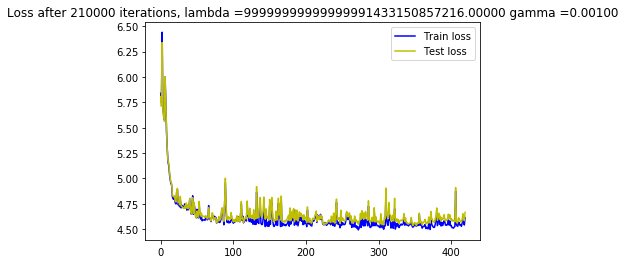

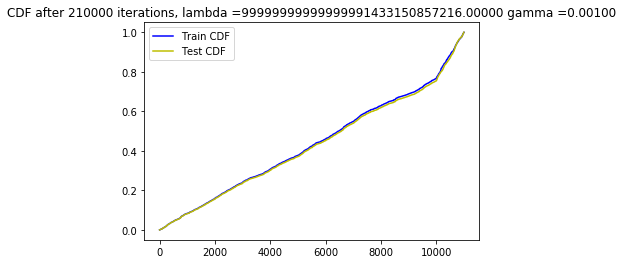

 44%|████▍     | 210009/473047 [2:08:02<37:46:42,  1.93it/s]

New score:  0.030253997
Train score:  0.07545728
Test score:  0.07264488


 45%|████▌     | 214997/473047 [2:10:53<57:29, 74.81it/s]   

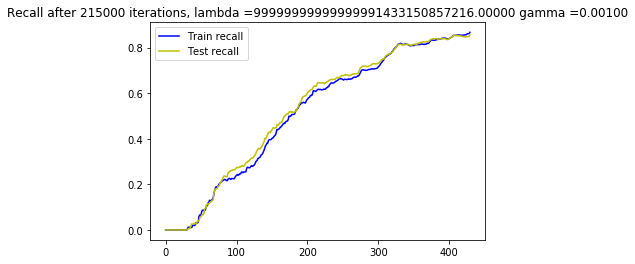

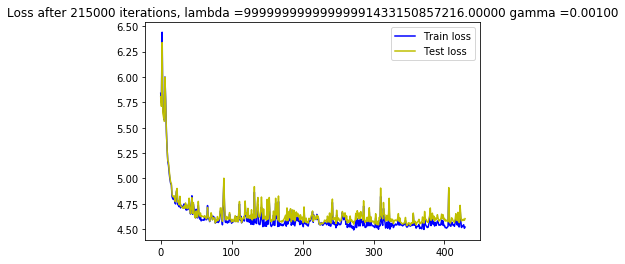

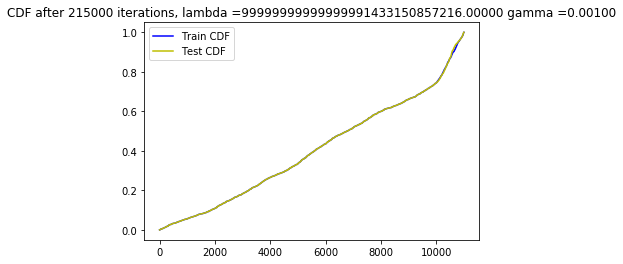

 45%|████▌     | 215013/473047 [2:11:05<23:27:43,  3.05it/s]

New score:  0.024796497
Train score:  0.12712806
Test score:  0.09512715


 47%|████▋     | 219997/473047 [2:14:10<56:38, 74.47it/s]   

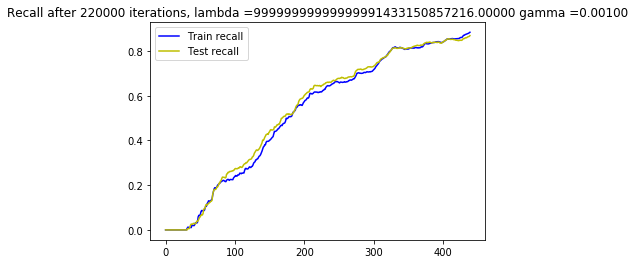

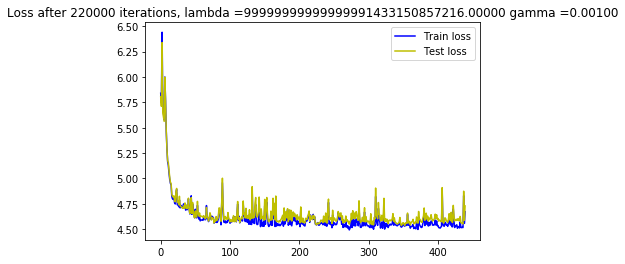

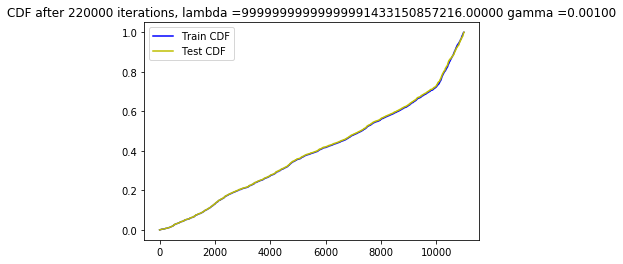

 47%|████▋     | 220009/473047 [2:14:12<45:58:20,  1.53it/s]

New score:  0.038270213
Train score:  0.059817802
Test score:  0.12401076


 48%|████▊     | 224993/473047 [2:17:05<55:49, 74.05it/s]   

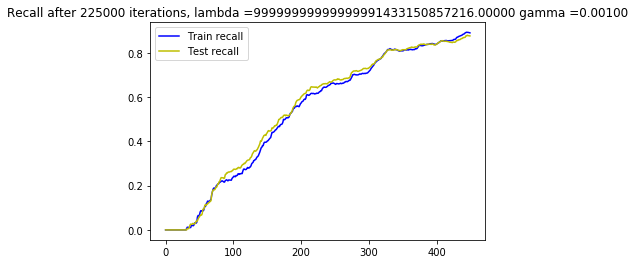

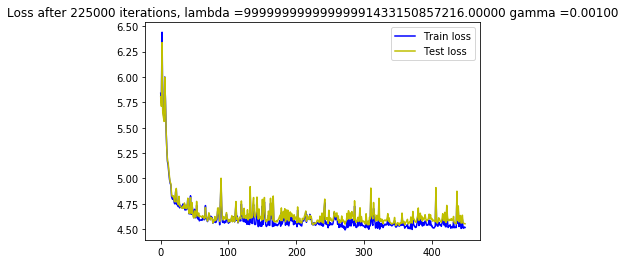

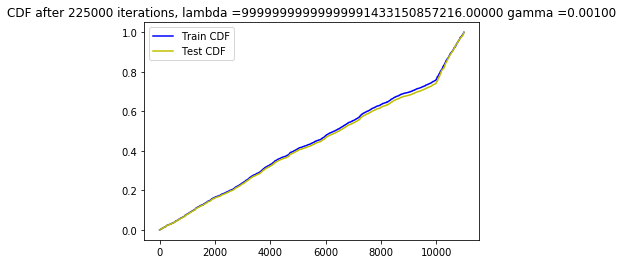

 48%|████▊     | 225009/473047 [2:17:18<22:50:25,  3.02it/s]

New score:  0.042903688
Train score:  0.08665906
Test score:  0.115452126


 49%|████▊     | 229995/473047 [2:20:13<56:38, 71.52it/s]   

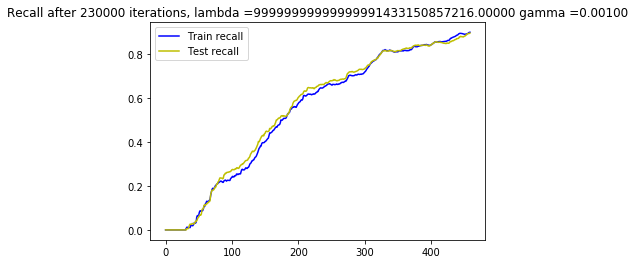

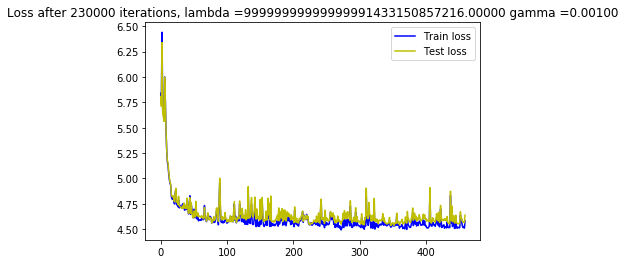

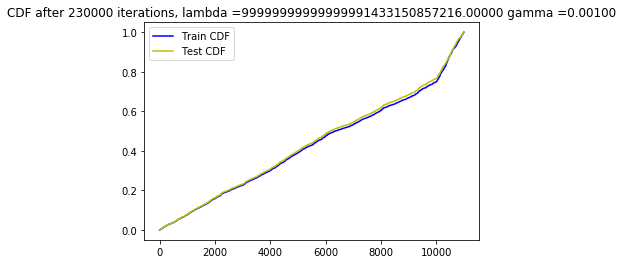

 49%|████▊     | 230011/473047 [2:20:26<23:41:49,  2.85it/s]

New score:  0.016212592
Train score:  0.08069983
Test score:  0.048110686


 50%|████▉     | 234993/473047 [2:23:40<57:14, 69.32it/s]    

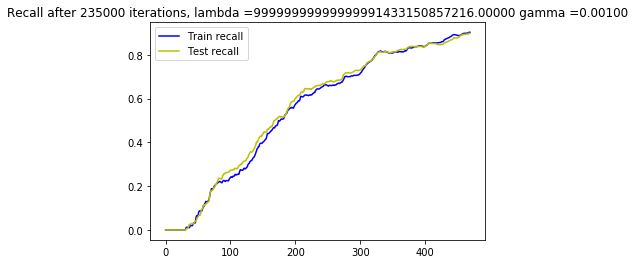

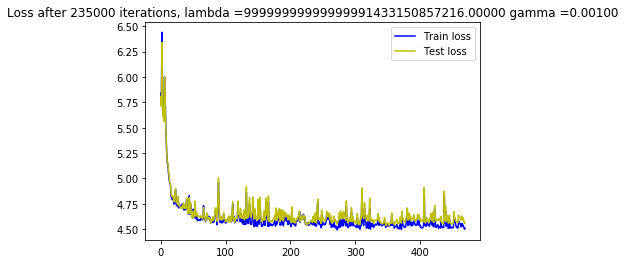

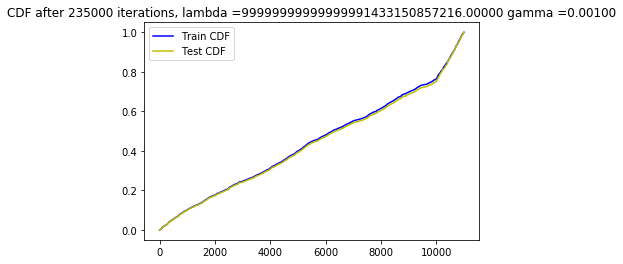

 50%|████▉     | 235008/473047 [2:23:42<23:23:59,  2.83it/s]

New score:  0.02013253
Train score:  0.07342728
Test score:  0.117902


 51%|█████     | 239999/473047 [2:26:44<48:22, 80.30it/s]    

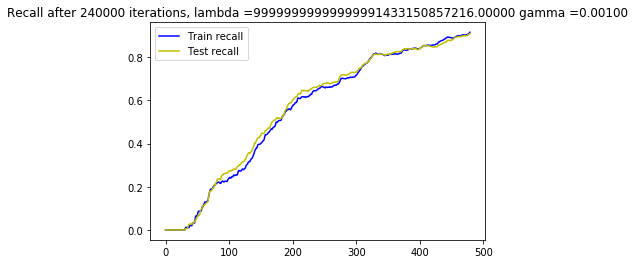

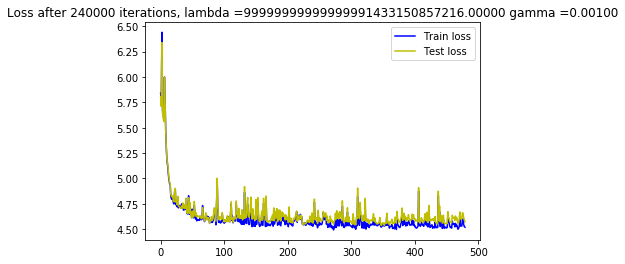

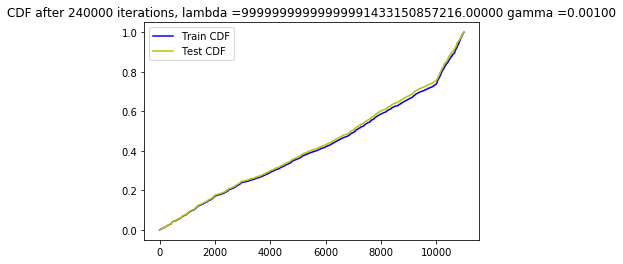

 51%|█████     | 240017/473047 [2:26:57<20:13:15,  3.20it/s]

New score:  0.013504748
Train score:  0.0691242
Test score:  0.049254607


 52%|█████▏    | 244995/473047 [2:29:52<48:50, 77.82it/s]   

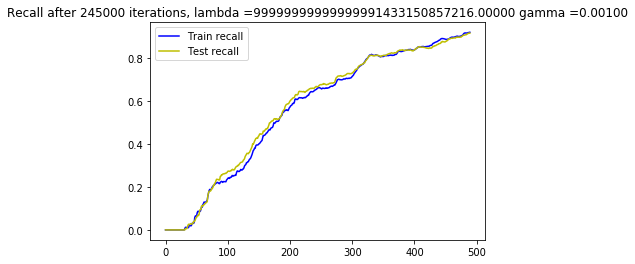

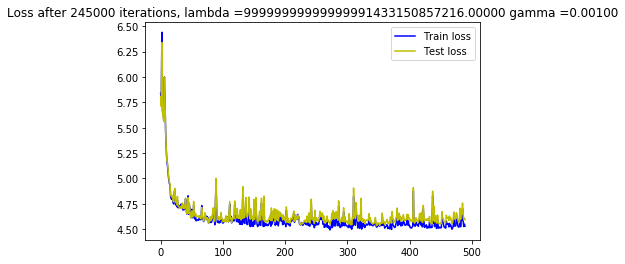

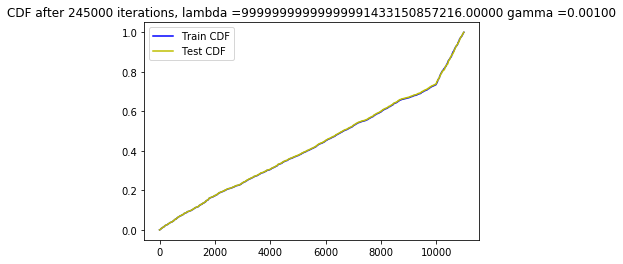

 52%|█████▏    | 245011/473047 [2:30:05<22:14:57,  2.85it/s]

New score:  0.052083146
Train score:  0.061196916
Test score:  0.05855149


 53%|█████▎    | 250000/473047 [2:33:01<48:06, 77.26it/s]    

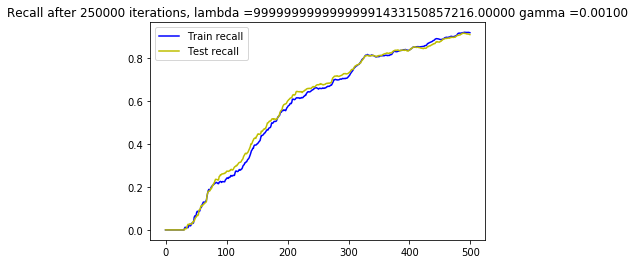

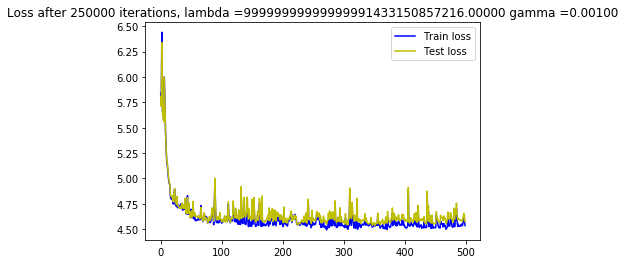

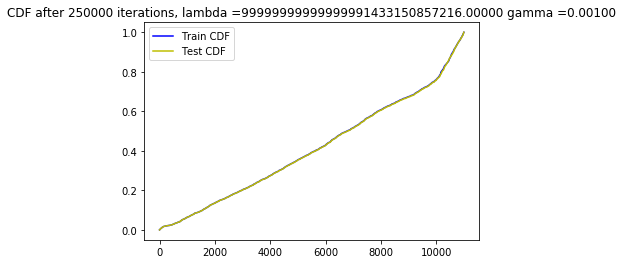

 53%|█████▎    | 250016/473047 [2:33:14<21:50:00,  2.84it/s]

New score:  0.018770799
Train score:  0.10473956
Test score:  0.1072695


 54%|█████▍    | 254996/473047 [2:36:20<46:17, 78.51it/s]    

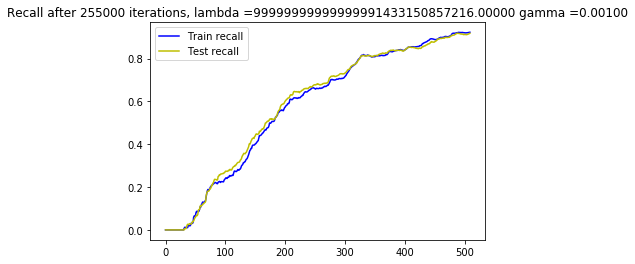

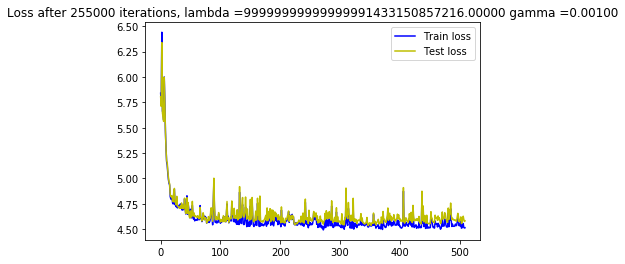

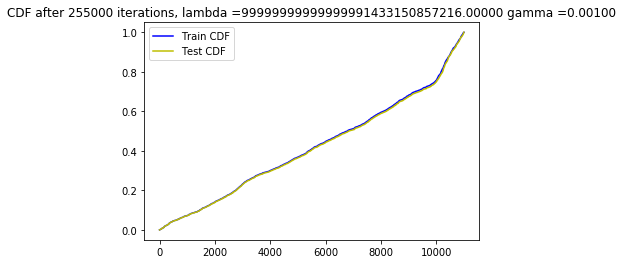

 54%|█████▍    | 255009/473047 [2:36:22<33:43:11,  1.80it/s]

New score:  0.025502171
Train score:  0.0607721
Test score:  0.1198105


 55%|█████▍    | 259998/473047 [2:39:16<46:48, 75.86it/s]    

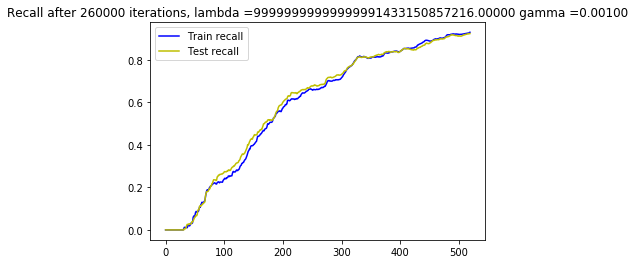

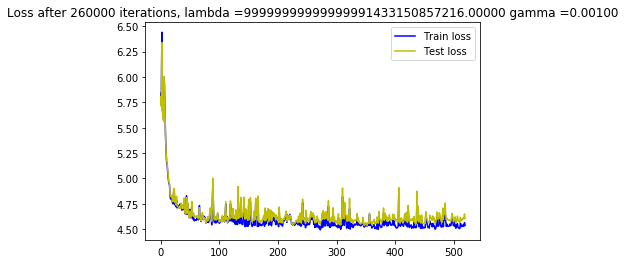

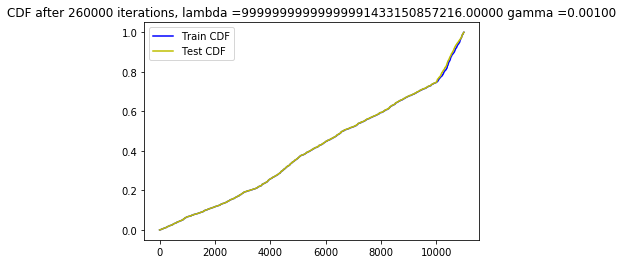

 55%|█████▍    | 260014/473047 [2:39:29<19:53:41,  2.97it/s]

New score:  0.018902512
Train score:  0.05686869
Test score:  0.050011713


 56%|█████▌    | 264999/473047 [2:42:30<47:03, 73.69it/s]    

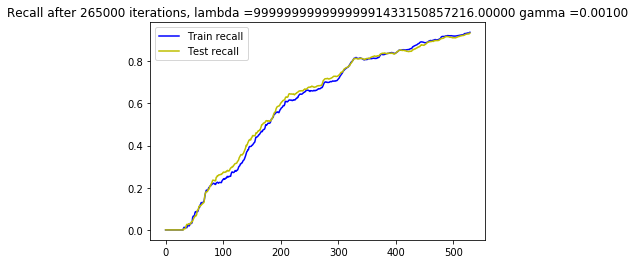

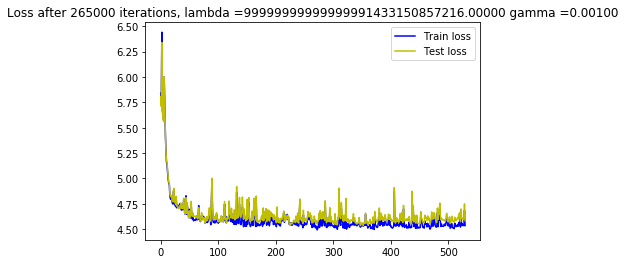

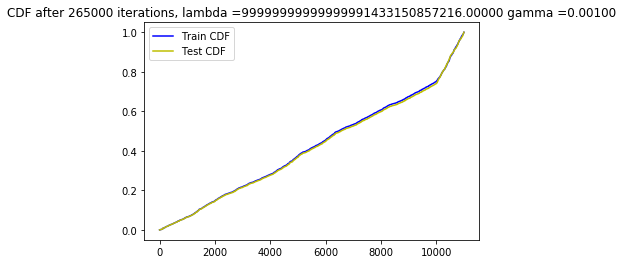

 56%|█████▌    | 265009/473047 [2:42:31<74:50:26,  1.30s/it] 

New score:  0.042830117
Train score:  0.13268241
Test score:  0.10716213


 57%|█████▋    | 269993/473047 [2:45:25<46:18, 73.09it/s]   

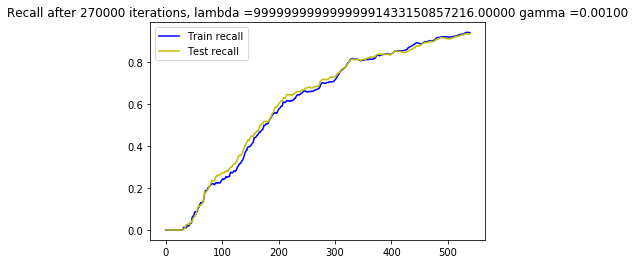

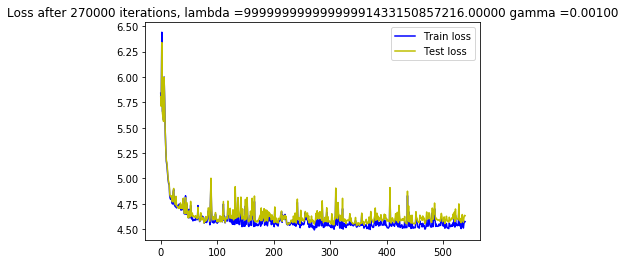

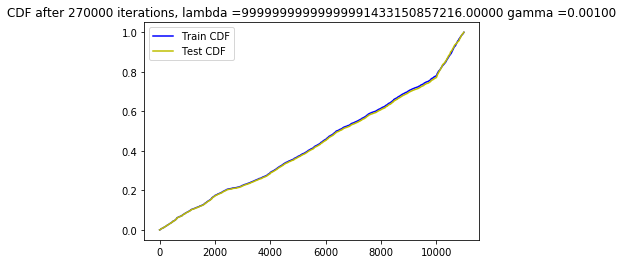

 57%|█████▋    | 270009/473047 [2:45:38<18:55:35,  2.98it/s]

New score:  0.014842978
Train score:  0.07295352
Test score:  0.0406359


 58%|█████▊    | 274997/473047 [2:48:28<45:20, 72.79it/s]   

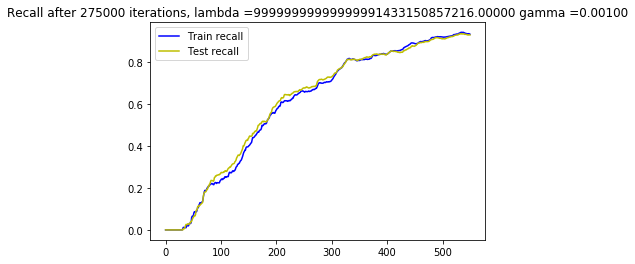

 58%|█████▊    | 274997/473047 [2:48:40<45:20, 72.79it/s]

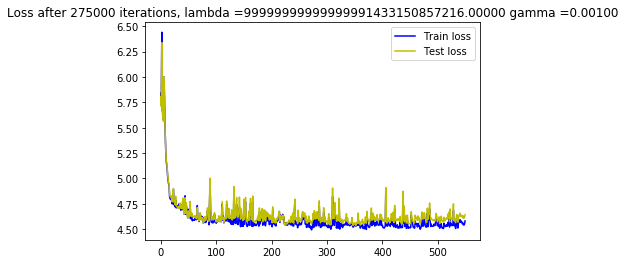

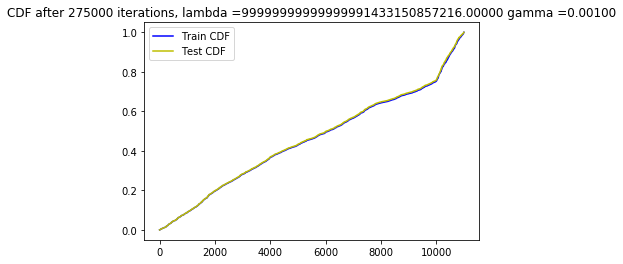

 58%|█████▊    | 275009/473047 [2:48:40<35:48:28,  1.54it/s]

New score:  0.017108295
Train score:  0.0934075
Test score:  0.03789082


 59%|█████▉    | 279997/473047 [2:51:35<43:18, 74.31it/s]   

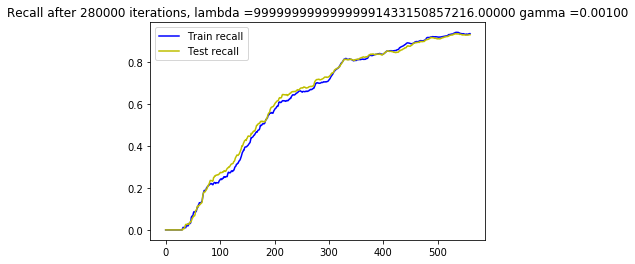

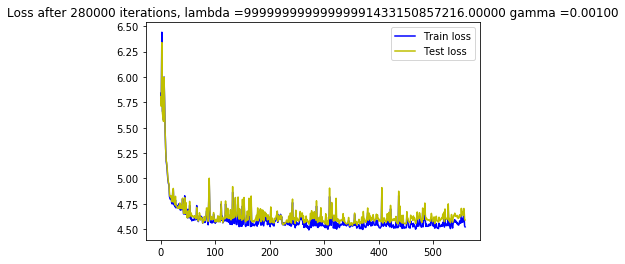

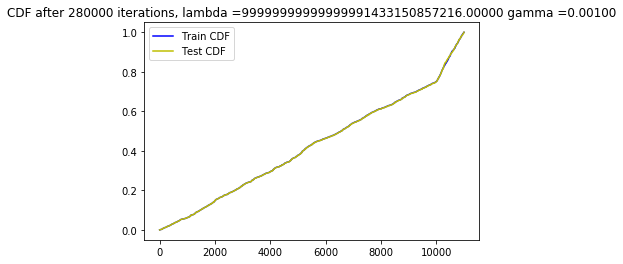

 59%|█████▉    | 280013/473047 [2:51:47<17:57:02,  2.99it/s]

New score:  0.043224614
Train score:  0.067602456
Test score:  0.0954592


 60%|██████    | 284997/473047 [2:54:41<43:28, 72.09it/s]   

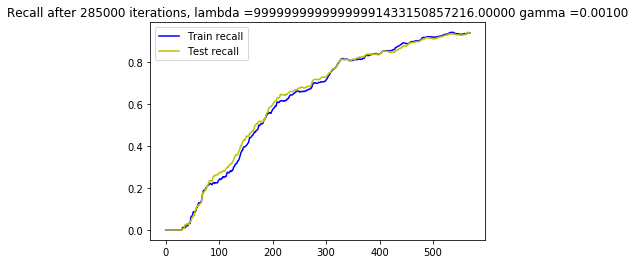

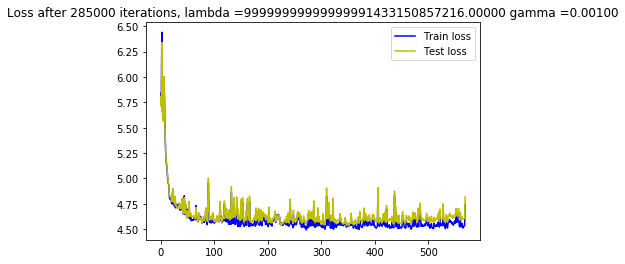

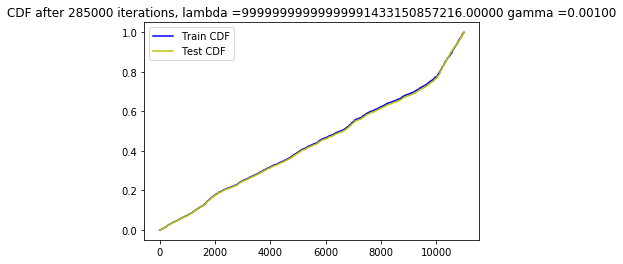

 60%|██████    | 285013/473047 [2:54:54<17:26:52,  2.99it/s]

New score:  0.009659352
Train score:  0.06349607
Test score:  0.09194402


 61%|██████▏   | 289997/473047 [2:58:00<42:24, 71.93it/s]   

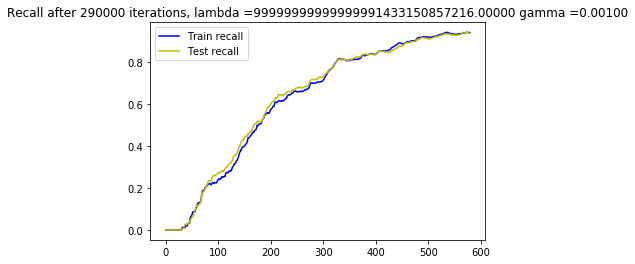

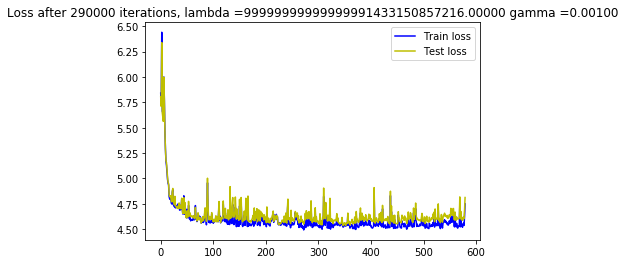

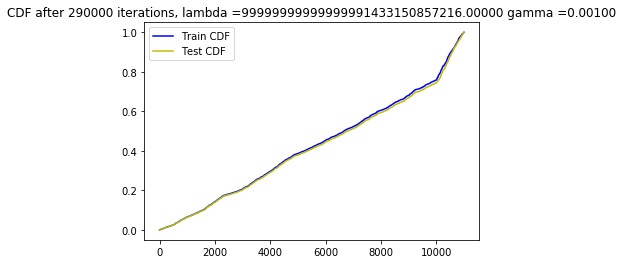

 61%|██████▏   | 290009/473047 [2:58:01<33:12:55,  1.53it/s]

New score:  0.007838437
Train score:  0.056900937
Test score:  0.04423335


 62%|██████▏   | 294997/473047 [3:00:55<41:32, 71.42it/s]   

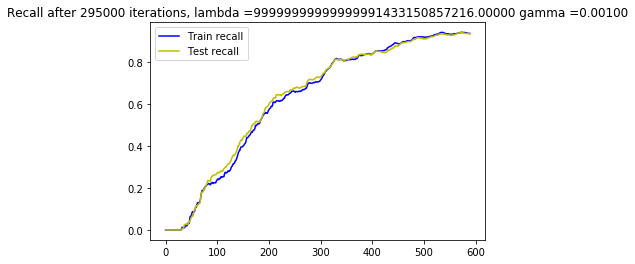

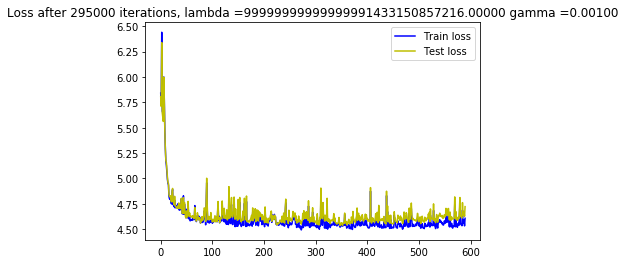

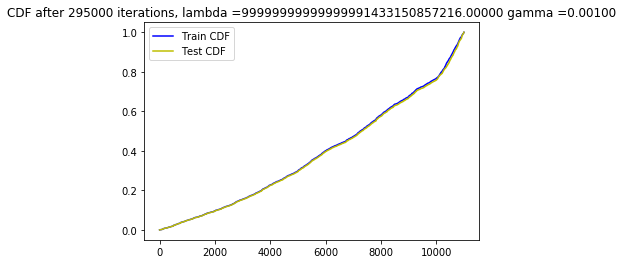

 62%|██████▏   | 295013/473047 [3:01:07<16:32:13,  2.99it/s]

New score:  0.03447748
Train score:  0.09877206
Test score:  0.11353854


 63%|██████▎   | 299996/473047 [3:04:10<39:16, 73.45it/s]   

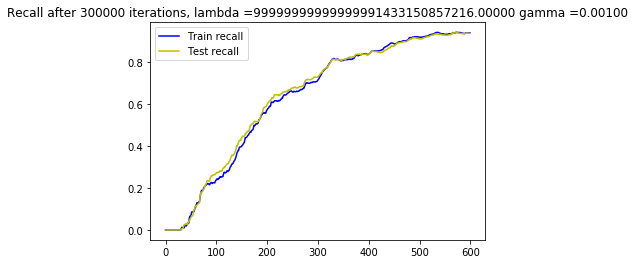

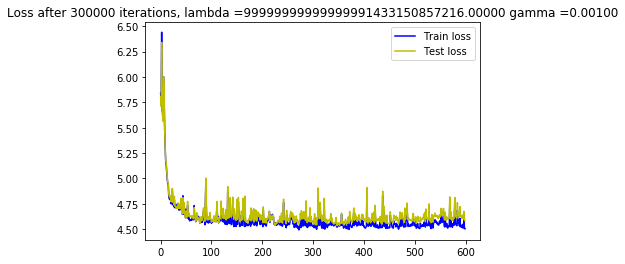

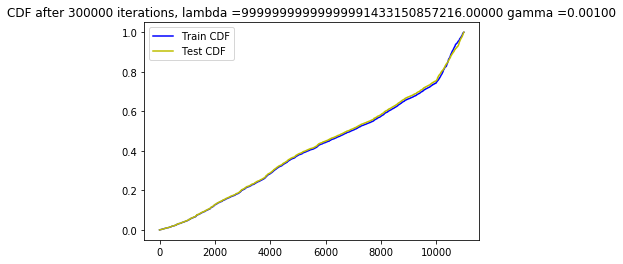

 63%|██████▎   | 300009/473047 [3:04:12<25:00:12,  1.92it/s]

New score:  0.036451112
Train score:  0.032931343
Test score:  0.058040183


 64%|██████▍   | 304995/473047 [3:07:05<38:10, 73.38it/s]   

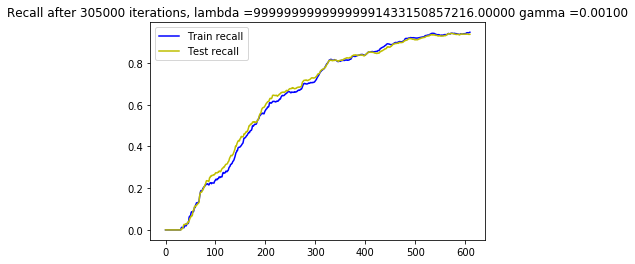

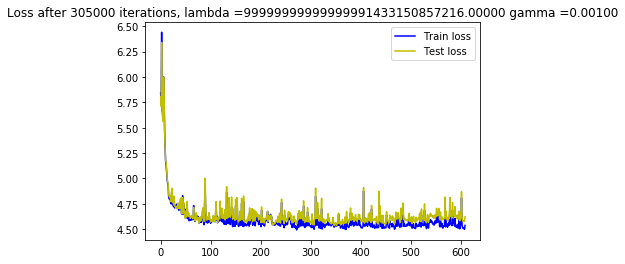

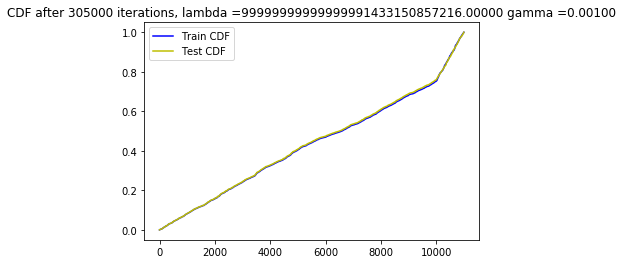

 64%|██████▍   | 305011/473047 [3:07:18<15:40:15,  2.98it/s]

New score:  0.025880134
Train score:  0.07125367
Test score:  0.09473532


 66%|██████▌   | 309999/473047 [3:10:12<36:52, 73.70it/s]   

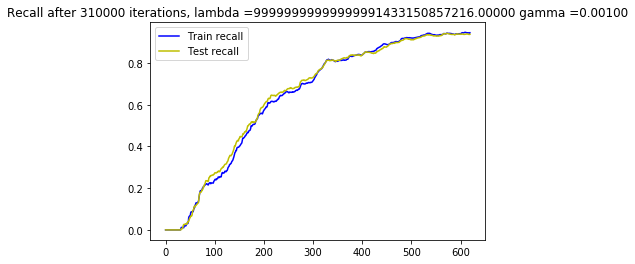

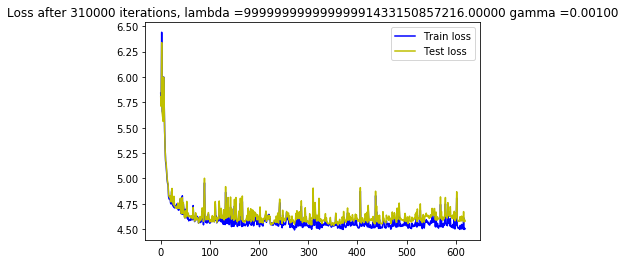

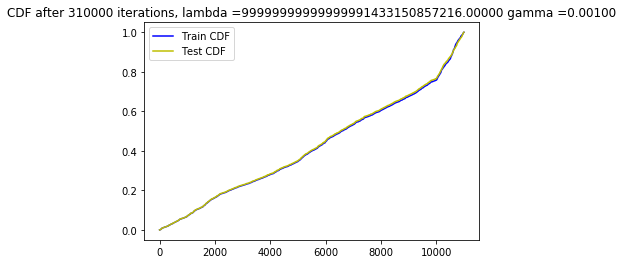

 66%|██████▌   | 310015/473047 [3:10:24<15:12:37,  2.98it/s]

New score:  0.016544122
Train score:  0.0559035
Test score:  0.04101275


 67%|██████▋   | 314997/473047 [3:13:18<35:55, 73.33it/s]   

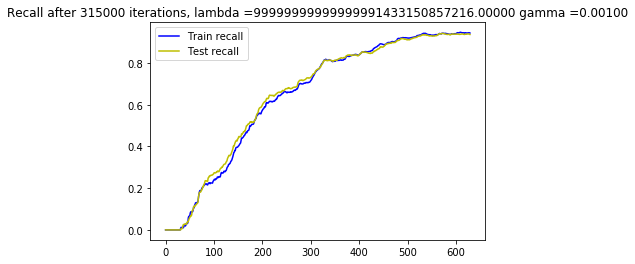

 67%|██████▋   | 314997/473047 [3:13:30<35:55, 73.33it/s]

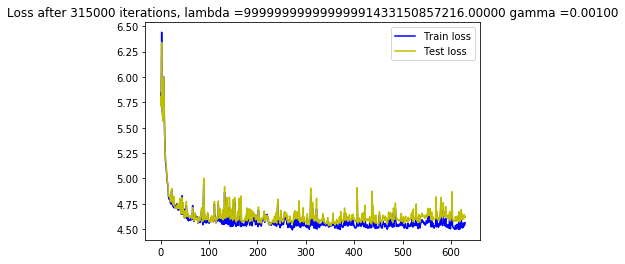

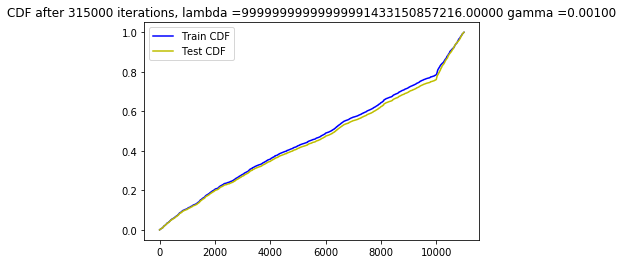

 67%|██████▋   | 315009/473047 [3:13:30<28:41:33,  1.53it/s]

New score:  0.022626685
Train score:  0.060770582
Test score:  0.042853888


 68%|██████▊   | 319997/473047 [3:16:24<34:28, 73.97it/s]    

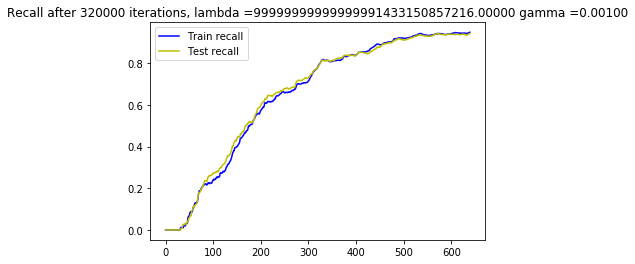

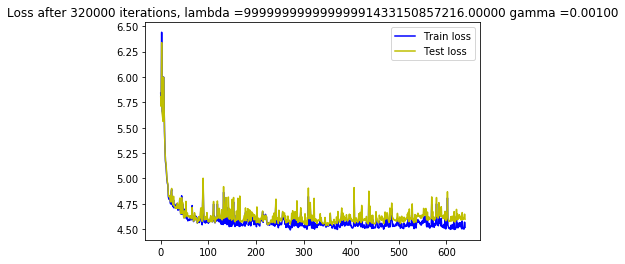

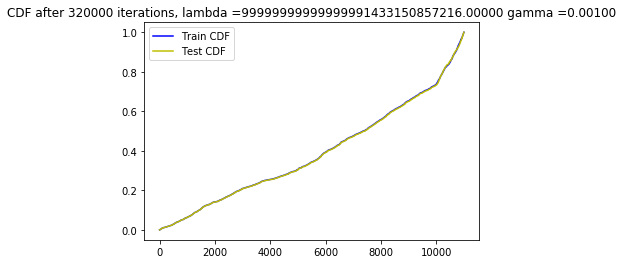

 68%|██████▊   | 320013/473047 [3:16:36<14:04:17,  3.02it/s]

New score:  0.03644558
Train score:  0.09886067
Test score:  0.1099443


 69%|██████▊   | 324997/473047 [3:19:30<33:56, 72.69it/s]   

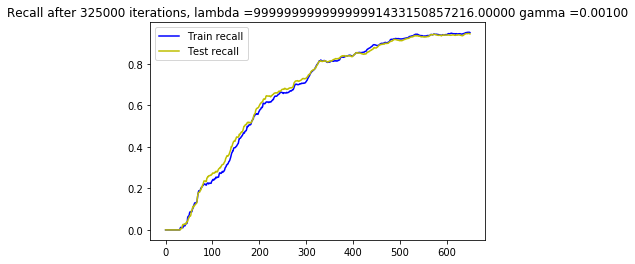

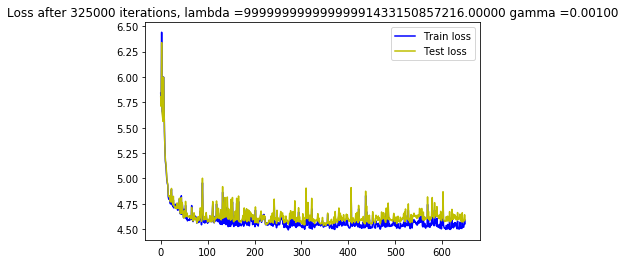

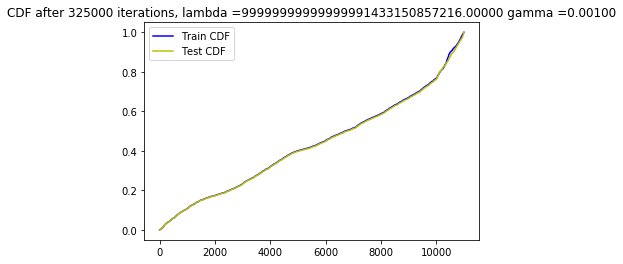

 69%|██████▊   | 325013/473047 [3:19:43<13:47:22,  2.98it/s]

New score:  0.019745935
Train score:  0.068577155
Test score:  0.18513757


 70%|██████▉   | 329997/473047 [3:22:37<31:36, 75.45it/s]   

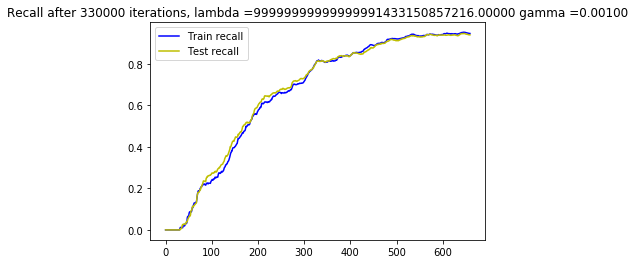

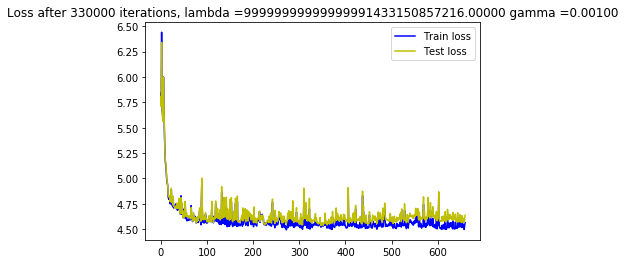

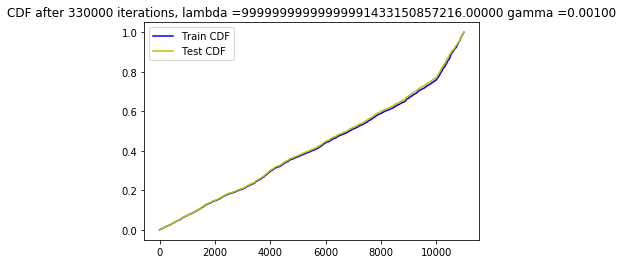

 70%|██████▉   | 330013/473047 [3:22:50<13:16:32,  2.99it/s]

New score:  0.011191345
Train score:  0.09518689
Test score:  0.09999491


 71%|███████   | 334997/473047 [3:25:42<30:35, 75.20it/s]   

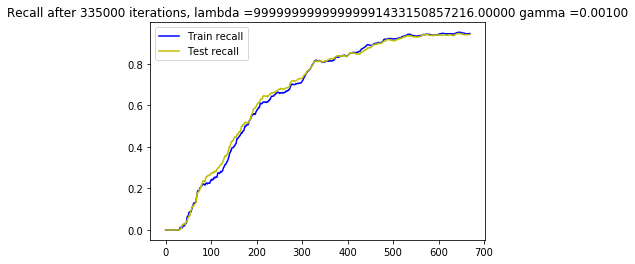

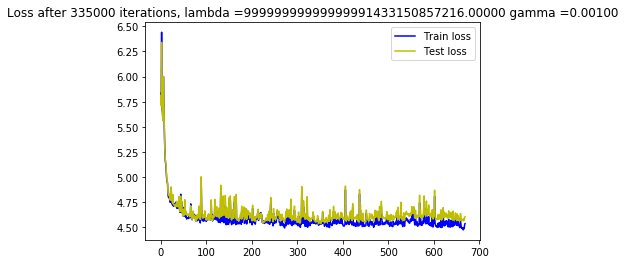

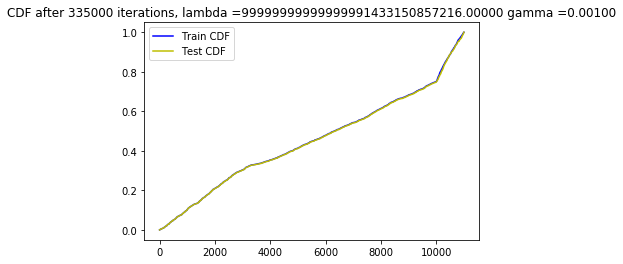

 71%|███████   | 335013/473047 [3:25:55<12:52:28,  2.98it/s]

New score:  0.020093586
Train score:  0.05093377
Test score:  0.11630057


 72%|███████▏  | 339998/473047 [3:28:47<29:20, 75.58it/s]   

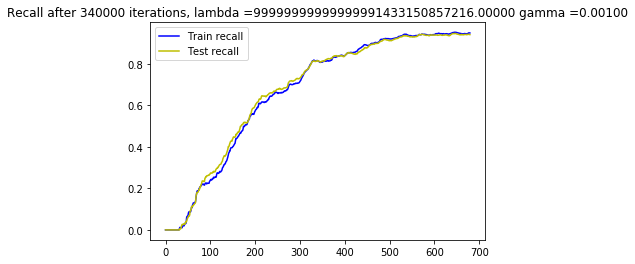

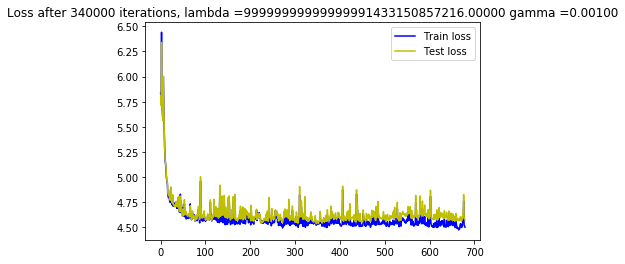

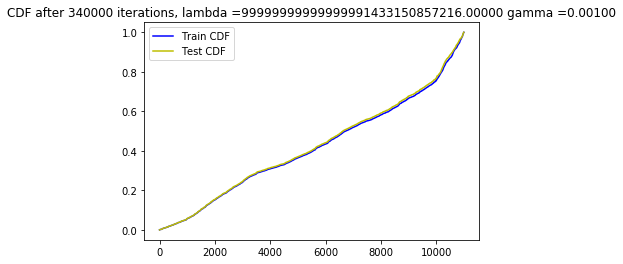

 72%|███████▏  | 340014/473047 [3:28:59<12:05:53,  3.05it/s]

New score:  0.012140007
Train score:  0.08207608
Test score:  0.054047137


 73%|███████▎  | 344997/473047 [3:31:51<29:14, 73.00it/s]   

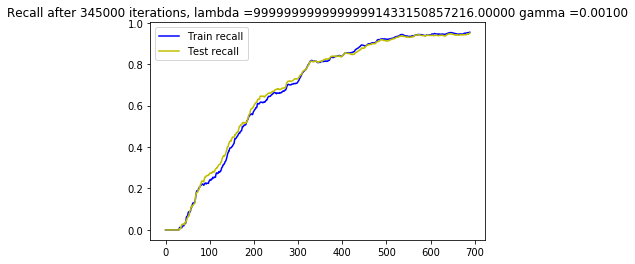

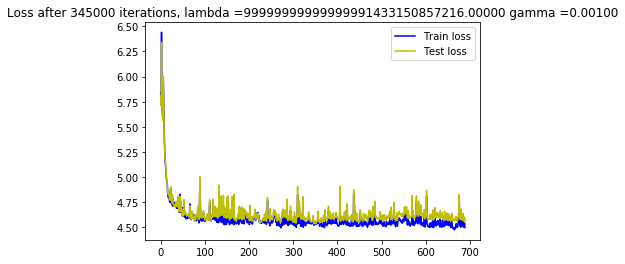

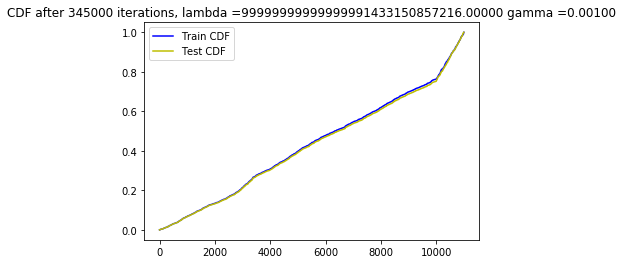

 73%|███████▎  | 345013/473047 [3:32:03<11:56:29,  2.98it/s]

New score:  0.013356316
Train score:  0.1733782
Test score:  0.0650738


 74%|███████▍  | 349997/473047 [3:34:58<28:06, 72.96it/s]    

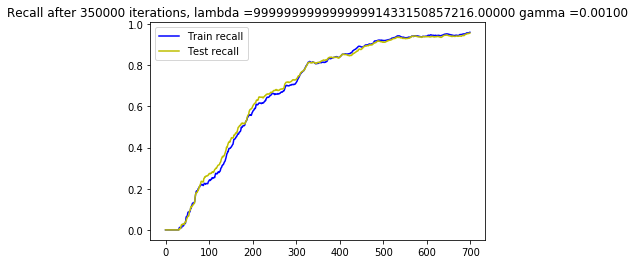

 74%|███████▍  | 349997/473047 [3:35:10<28:06, 72.96it/s]

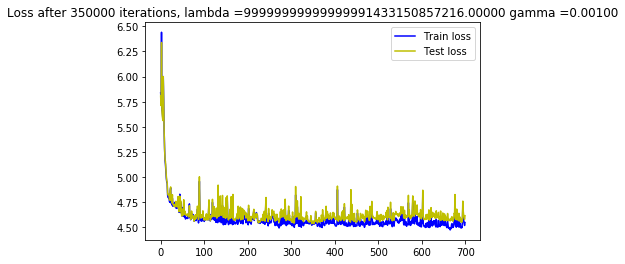

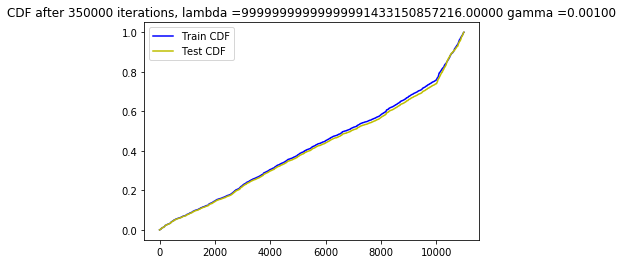

 74%|███████▍  | 350009/473047 [3:35:11<22:33:33,  1.52it/s]

New score:  0.017944153
Train score:  0.057972174
Test score:  0.081851676


 75%|███████▌  | 354993/473047 [3:38:06<27:03, 72.69it/s]   

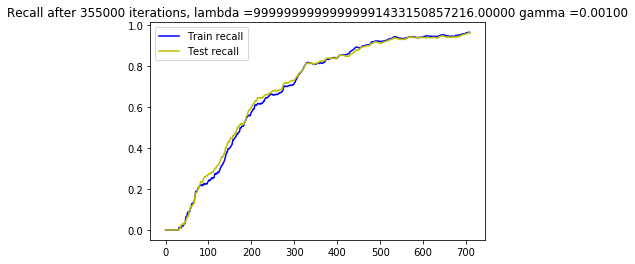

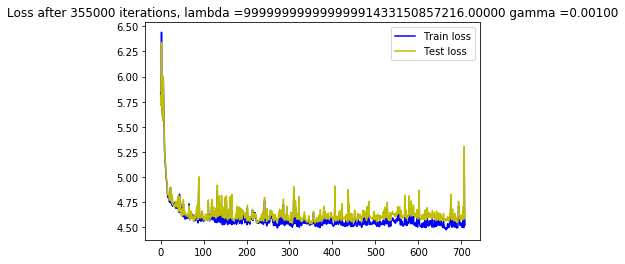

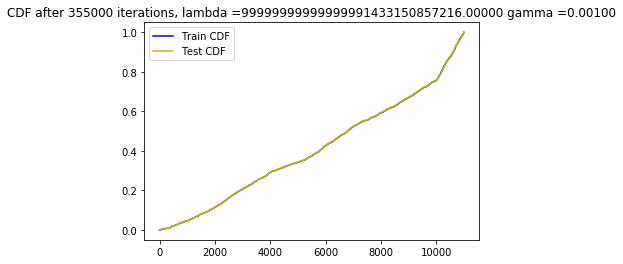

 75%|███████▌  | 355009/473047 [3:38:19<11:04:08,  2.96it/s]

New score:  0.004308255
Train score:  0.103687346
Test score:  0.08417529


 76%|███████▌  | 359996/473047 [3:41:07<23:14, 81.07it/s]   

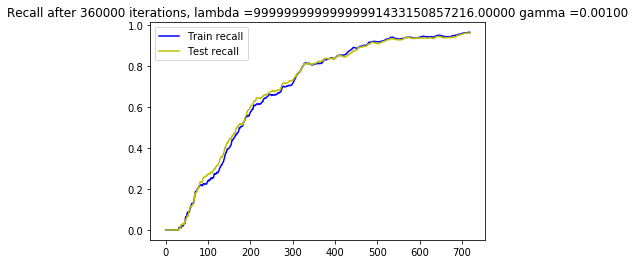

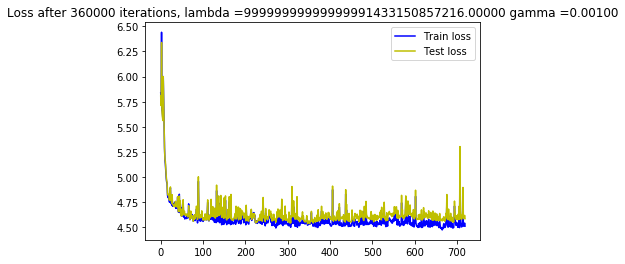

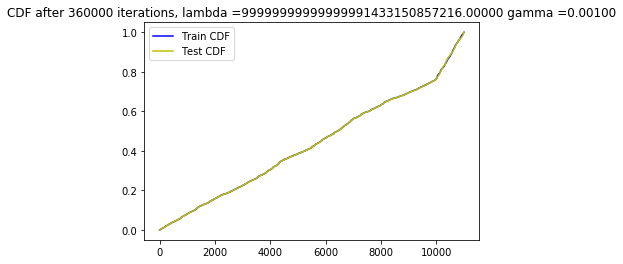

 76%|███████▌  | 360014/473047 [3:41:19<9:18:17,  3.37it/s] 

New score:  0.06672633
Train score:  0.08828746
Test score:  0.071325846


 77%|███████▋  | 364998/473047 [3:44:12<24:37, 73.15it/s]   

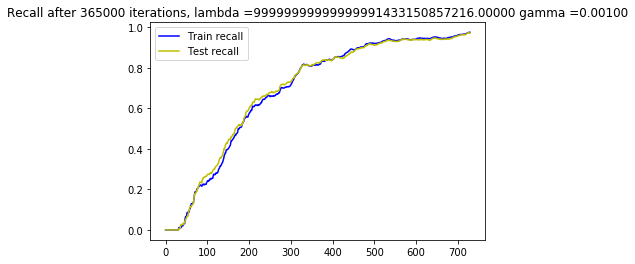

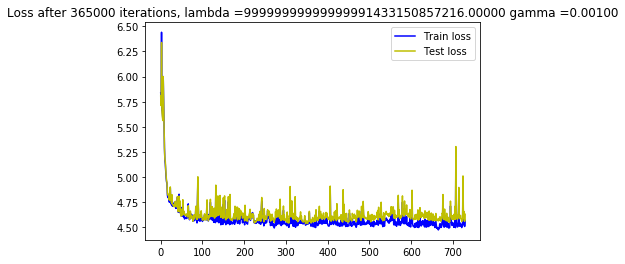

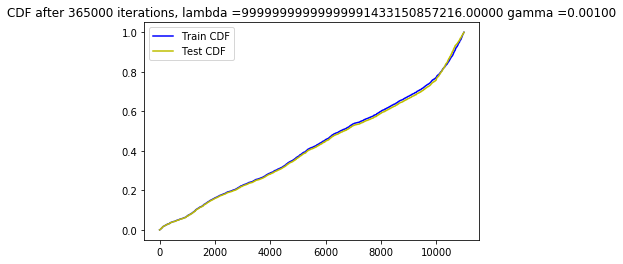

 77%|███████▋  | 365014/473047 [3:44:25<10:05:06,  2.98it/s]

New score:  0.05254229
Train score:  0.08268621
Test score:  0.0981759


 78%|███████▊  | 369994/473047 [3:47:30<23:40, 72.55it/s]   

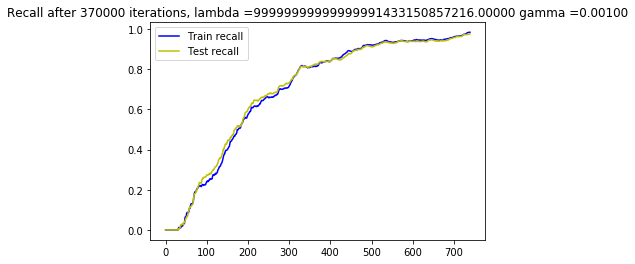

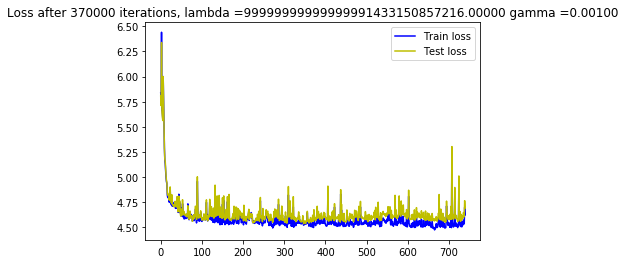

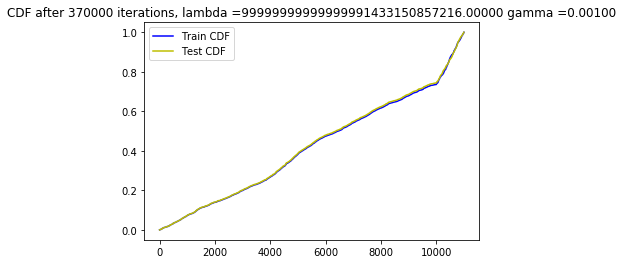

 78%|███████▊  | 370009/473047 [3:47:31<10:53:06,  2.63it/s]

New score:  0.005453461
Train score:  0.10892539
Test score:  0.06211435


 79%|███████▉  | 374997/473047 [3:50:25<21:56, 74.46it/s]   

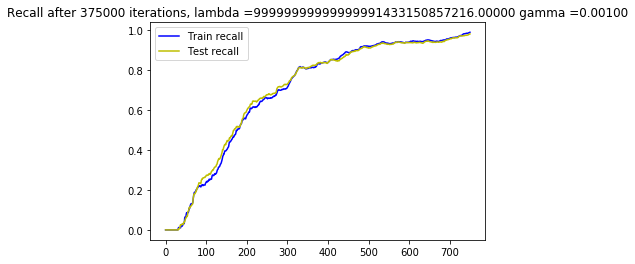

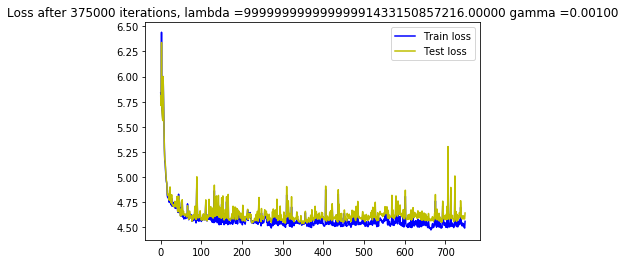

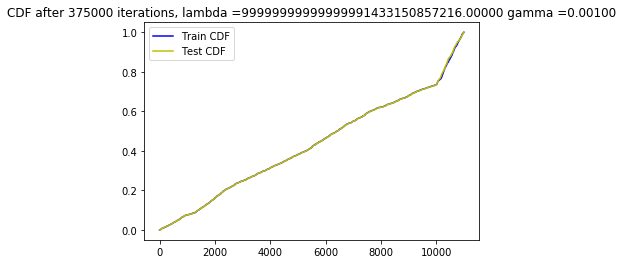

 79%|███████▉  | 375013/473047 [3:50:37<9:04:42,  3.00it/s] 

New score:  0.012925217
Train score:  0.03360487
Test score:  0.07019384


 80%|████████  | 379996/473047 [3:53:33<21:15, 72.95it/s]   

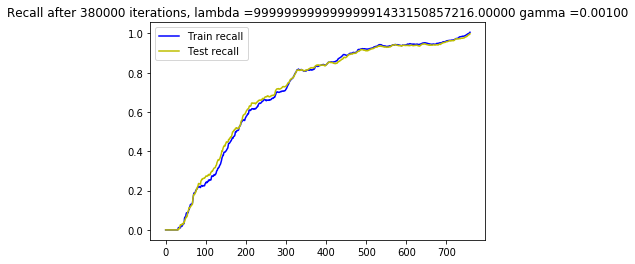

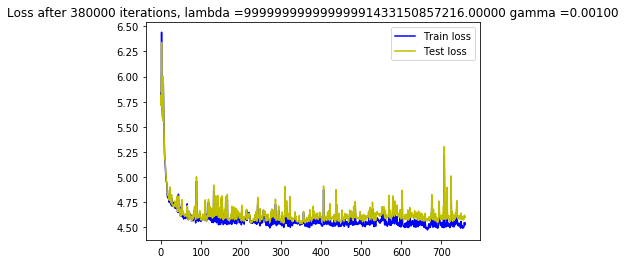

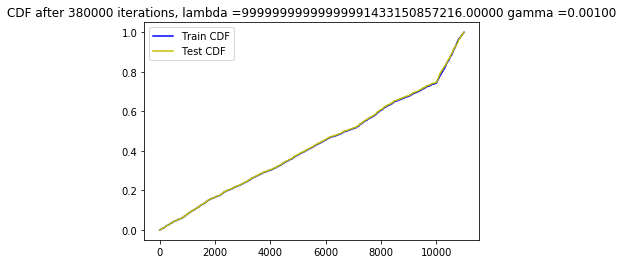

 80%|████████  | 380012/473047 [3:53:46<8:42:02,  2.97it/s] 

New score:  0.012284784
Train score:  0.06698731
Test score:  0.0821331


 81%|████████▏ | 384997/473047 [3:56:50<20:02, 73.20it/s]   

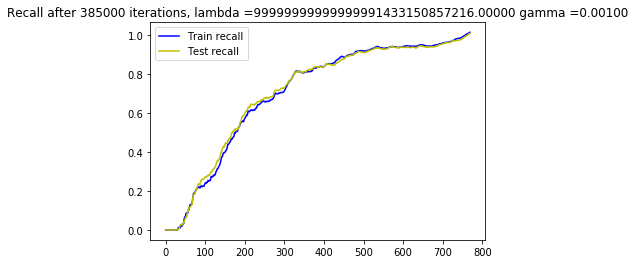

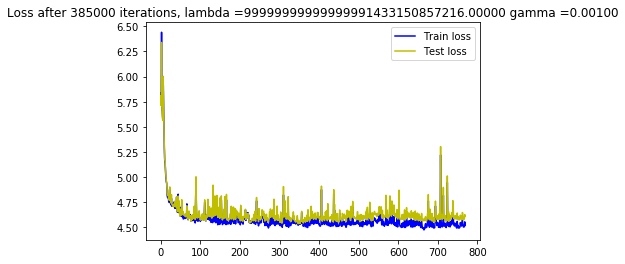

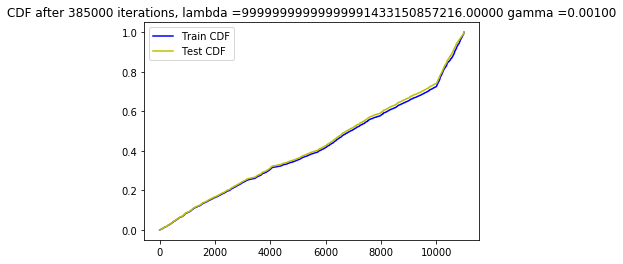

 81%|████████▏ | 385009/473047 [3:56:52<16:11:20,  1.51it/s]

New score:  0.031400118
Train score:  0.165116
Test score:  0.123767175


 82%|████████▏ | 389997/473047 [3:59:47<19:04, 72.56it/s]   

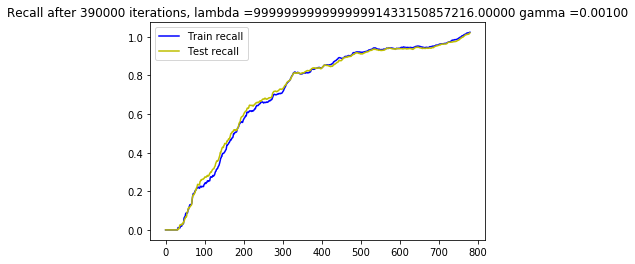

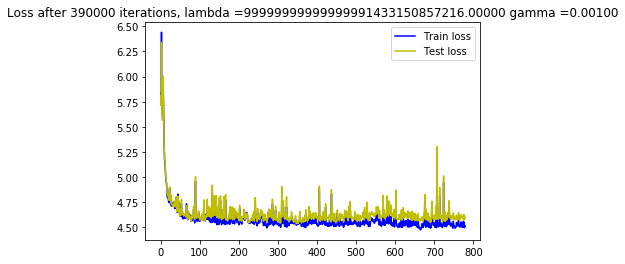

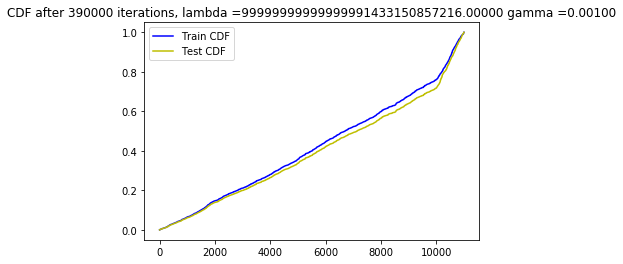

 82%|████████▏ | 390013/473047 [4:00:00<7:45:16,  2.97it/s] 

New score:  0.037263706
Train score:  0.14054112
Test score:  0.10901394


 84%|████████▎ | 395000/473047 [4:02:54<17:27, 74.53it/s]   

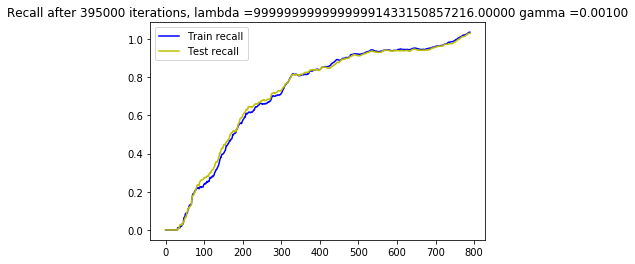

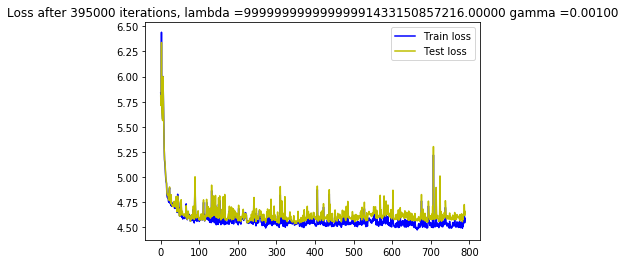

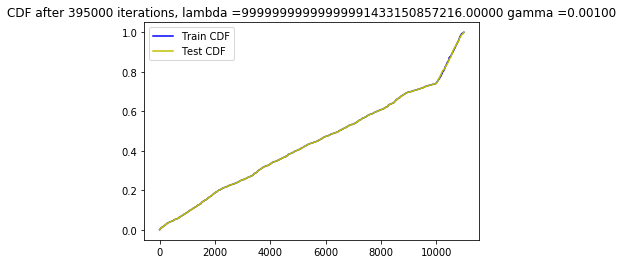

 84%|████████▎ | 395008/473047 [4:03:08<11:20:45,  1.91it/s]

New score:  0.0169838
Train score:  0.034447134
Test score:  0.051389832


 85%|████████▍ | 399993/473047 [4:06:10<16:23, 74.29it/s]   

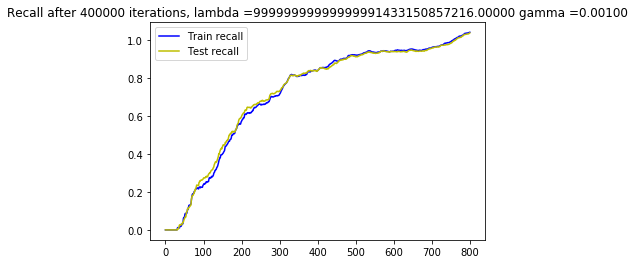

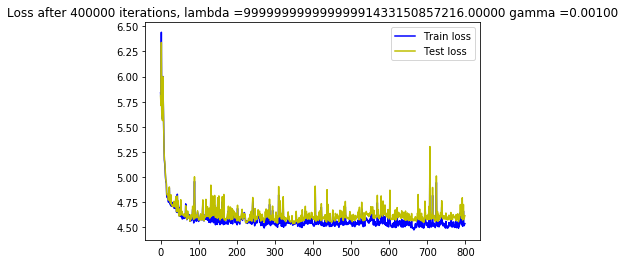

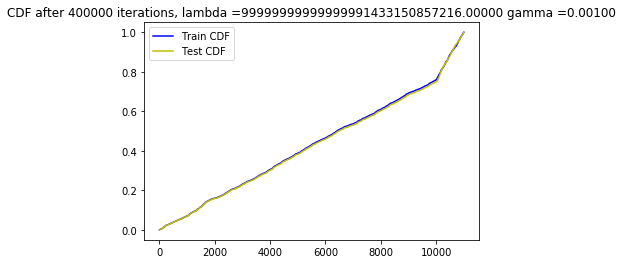

 85%|████████▍ | 400009/473047 [4:06:12<6:45:23,  3.00it/s]

New score:  0.0104149245
Train score:  0.06423123
Test score:  0.12289401


 86%|████████▌ | 404997/473047 [4:09:05<15:23, 73.67it/s]   

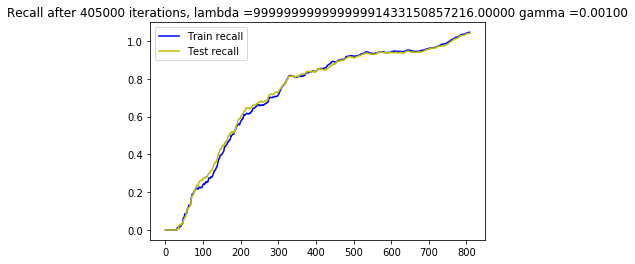

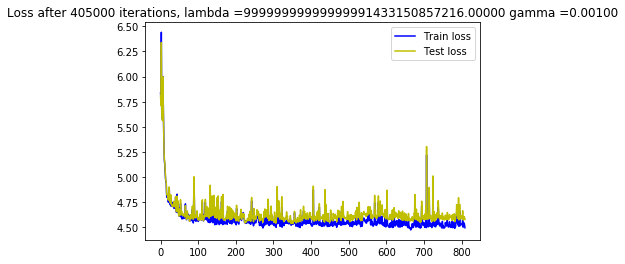

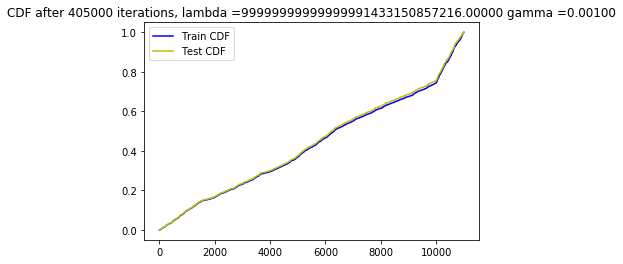

 86%|████████▌ | 405013/473047 [4:09:17<6:21:09,  2.97it/s]

New score:  0.012955241
Train score:  0.082572564
Test score:  0.07089043


 87%|████████▋ | 409998/473047 [4:12:11<13:54, 75.51it/s]   

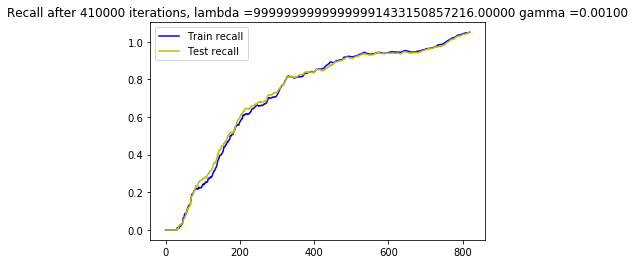

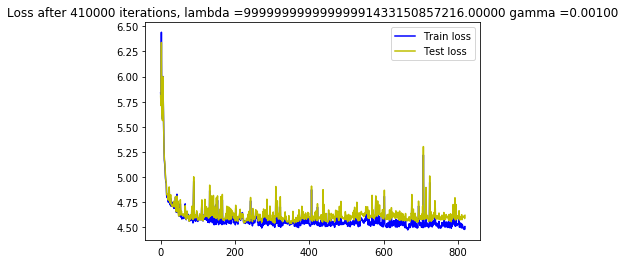

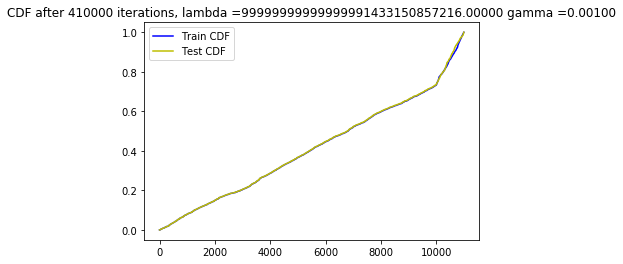

 87%|████████▋ | 410014/473047 [4:12:24<5:52:13,  2.98it/s]

New score:  0.031508923
Train score:  0.073223434
Test score:  0.12688884


 88%|████████▊ | 414993/473047 [4:15:17<13:19, 72.64it/s]   

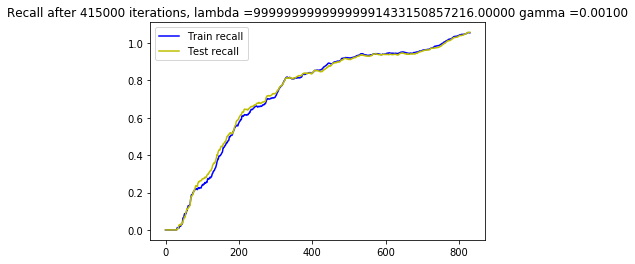

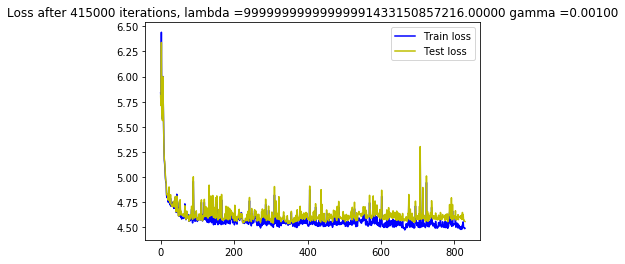

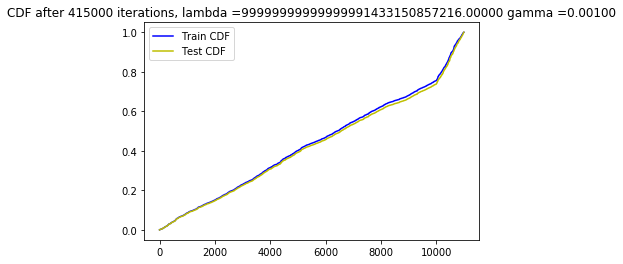

 88%|████████▊ | 415009/473047 [4:15:29<5:26:36,  2.96it/s]

New score:  0.021514941
Train score:  0.02881658
Test score:  0.07519353


 89%|████████▉ | 419993/473047 [4:18:24<12:09, 72.74it/s]  

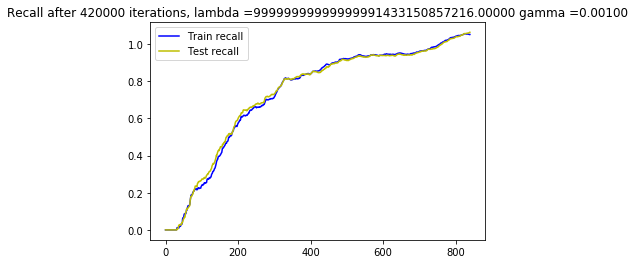

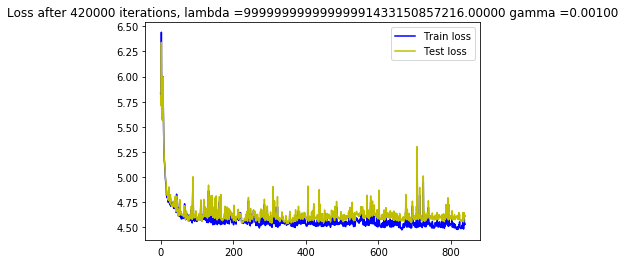

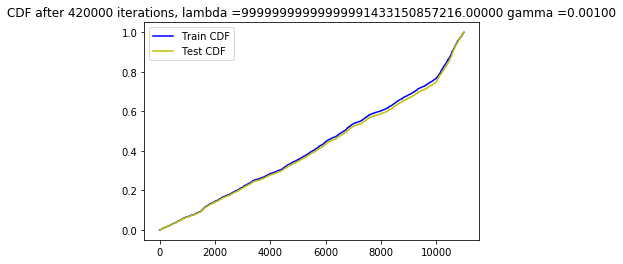

 89%|████████▉ | 420009/473047 [4:18:37<5:01:42,  2.93it/s]

New score:  0.031448327
Train score:  0.089228496
Test score:  0.04510674


 90%|████████▉ | 424996/473047 [4:21:33<11:02, 72.50it/s]   

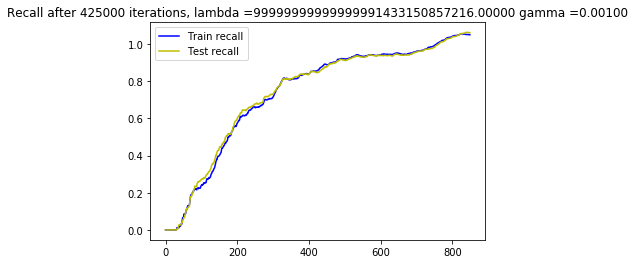

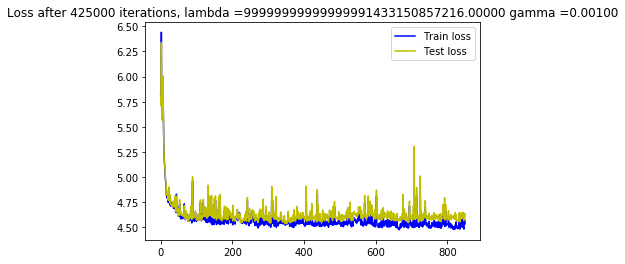

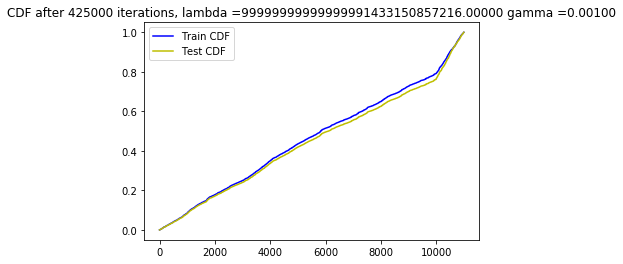

 90%|████████▉ | 425012/473047 [4:21:45<4:33:04,  2.93it/s]

New score:  0.028344104
Train score:  0.05299025
Test score:  0.050795954


 91%|█████████ | 429997/473047 [4:24:42<09:50, 72.94it/s]   

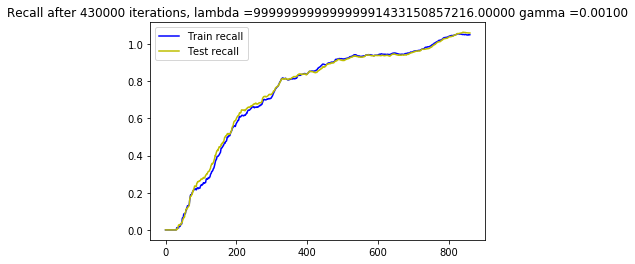

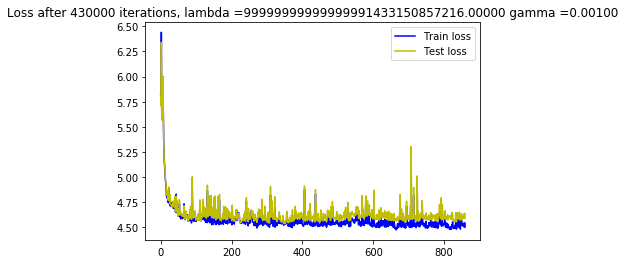

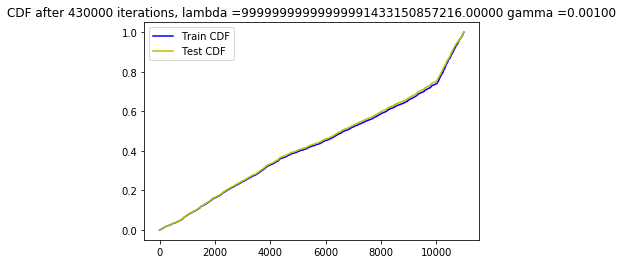

 91%|█████████ | 430013/473047 [4:24:54<3:59:31,  2.99it/s]

New score:  0.010865362
Train score:  0.061877925
Test score:  0.07742152


 92%|█████████▏| 434996/473047 [4:28:00<08:38, 73.38it/s]   

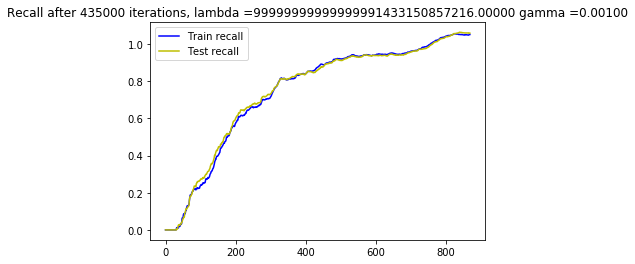

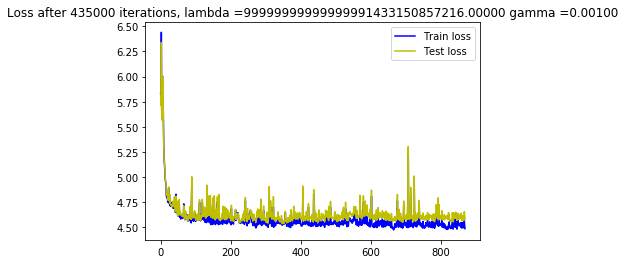

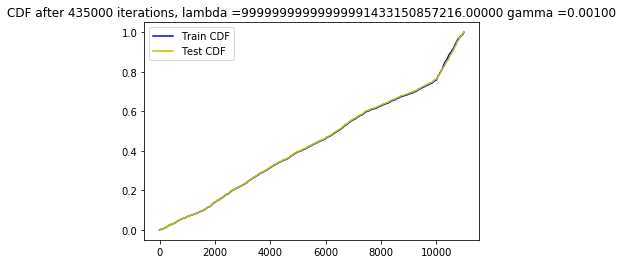

 92%|█████████▏| 435009/473047 [4:28:01<5:29:50,  1.92it/s]

New score:  0.015220495
Train score:  0.104436375
Test score:  0.059185483


 93%|█████████▎| 439997/473047 [4:30:55<07:27, 73.80it/s]  

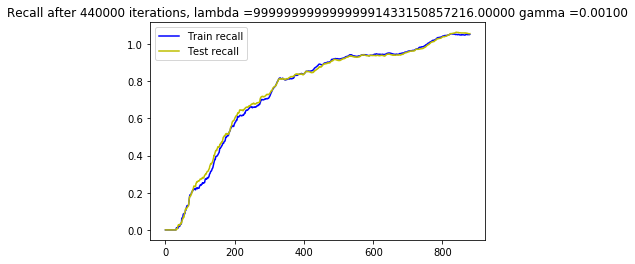

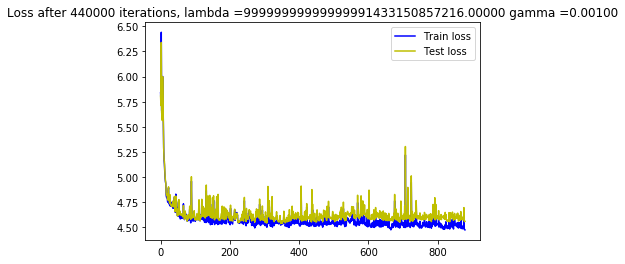

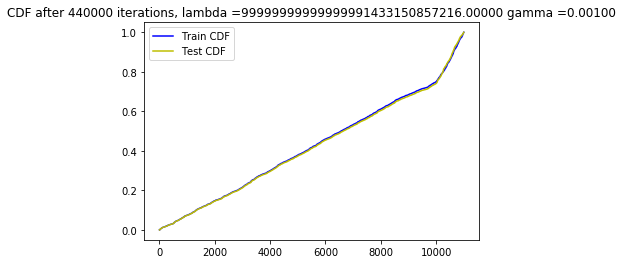

 93%|█████████▎| 440013/473047 [4:31:07<3:02:38,  3.01it/s]

New score:  0.021489076
Train score:  0.09975002
Test score:  0.07958201


 94%|█████████▍| 445000/473047 [4:34:10<06:18, 74.14it/s]  

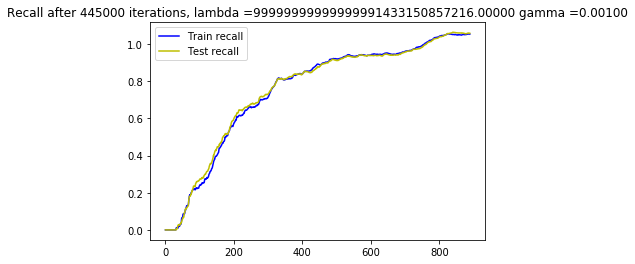

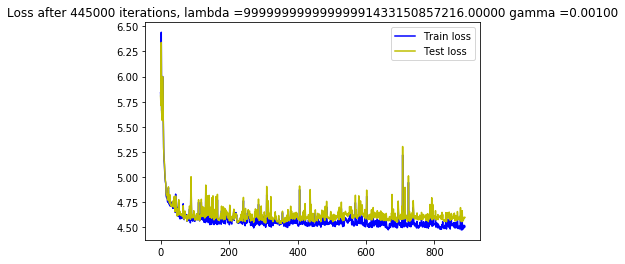

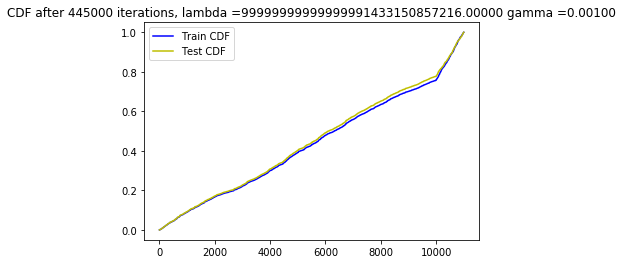

 94%|█████████▍| 445009/473047 [4:34:11<19:40:39,  2.53s/it]

New score:  0.02732484
Train score:  0.059500307
Test score:  0.05411769


 95%|█████████▌| 449993/473047 [4:37:02<05:16, 72.89it/s]   

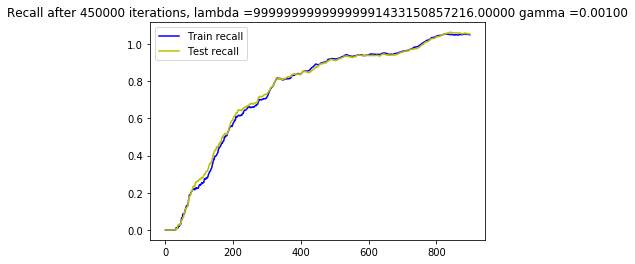

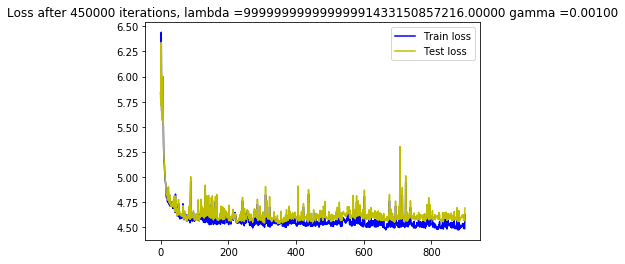

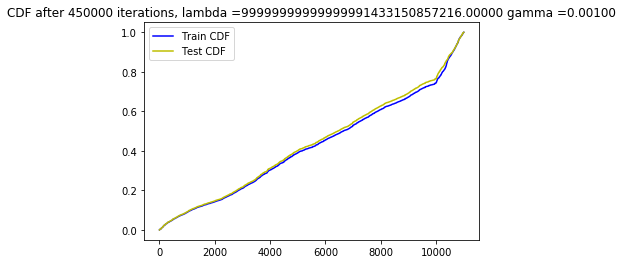

 95%|█████████▌| 450009/473047 [4:37:14<2:07:14,  3.02it/s]

New score:  0.02564242
Train score:  0.048651952
Test score:  0.03679147


 96%|█████████▌| 454998/473047 [4:40:10<03:40, 81.69it/s]  

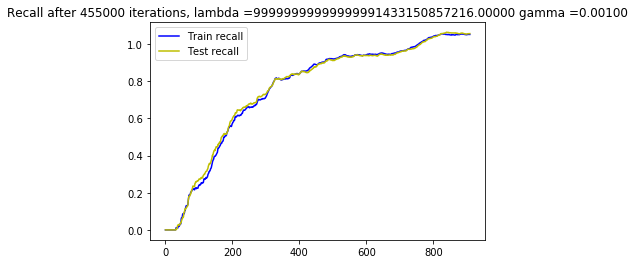

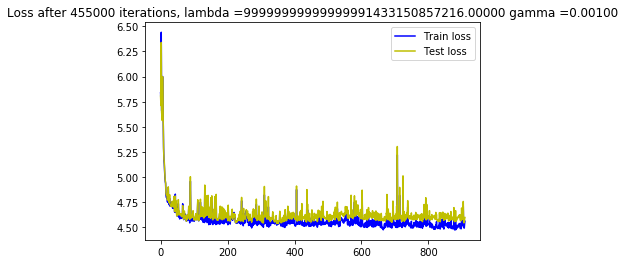

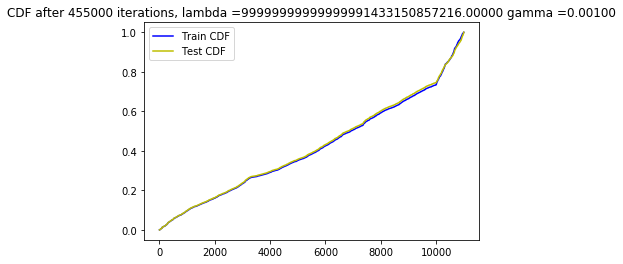

 96%|█████████▌| 455010/473047 [4:40:11<3:59:38,  1.25it/s]

New score:  0.011328174
Train score:  0.05363951
Test score:  0.14363232


 97%|█████████▋| 459994/473047 [4:43:00<02:40, 81.18it/s]  

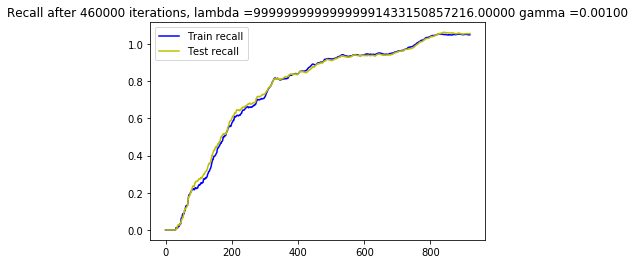

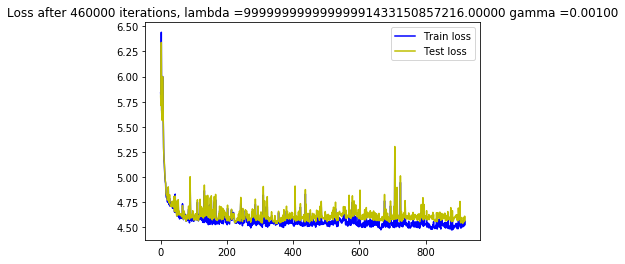

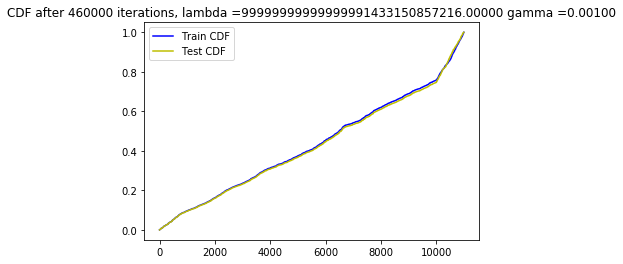

 97%|█████████▋| 460009/473047 [4:43:01<1:15:45,  2.87it/s]

New score:  0.012753752
Train score:  0.10727942
Test score:  0.048210125


 98%|█████████▊| 464993/473047 [4:45:39<01:38, 81.39it/s]  

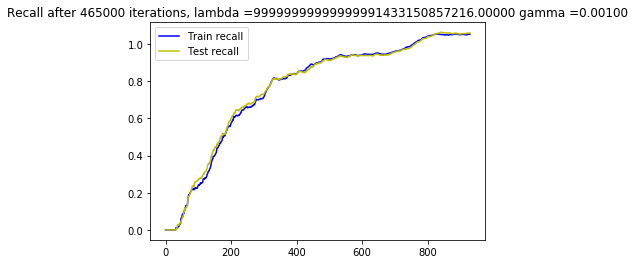

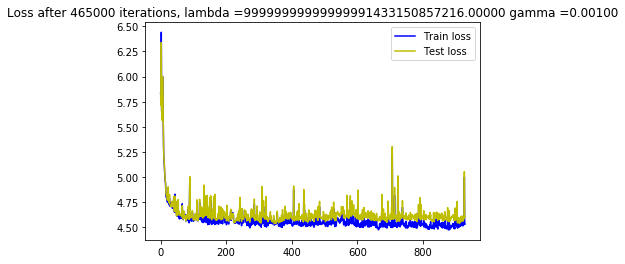

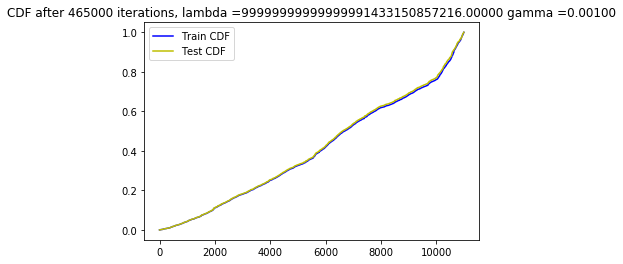

 98%|█████████▊| 465011/473047 [4:45:50<36:27,  3.67it/s]

New score:  0.028214896
Train score:  0.09590853
Test score:  0.07777232


 99%|█████████▉| 469999/473047 [4:48:28<00:36, 84.42it/s]

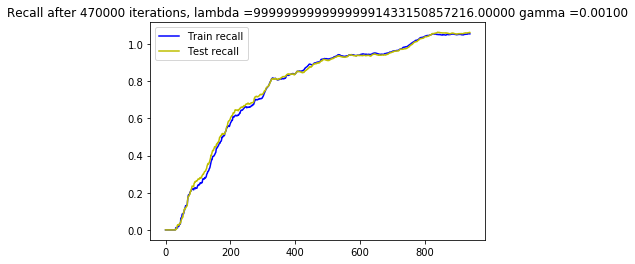

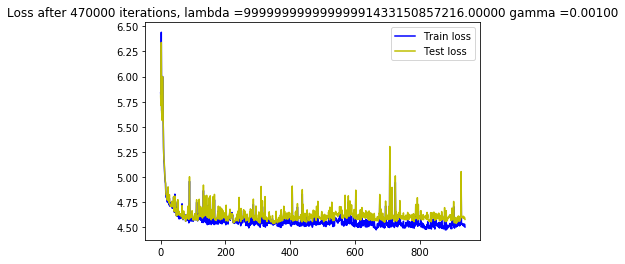

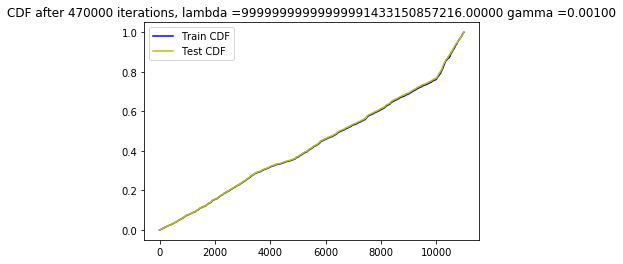

 99%|█████████▉| 470017/473047 [4:48:40<13:45,  3.67it/s]

New score:  0.031147014
Train score:  0.050623666
Test score:  0.070775464


100%|██████████| 473047/473047 [4:50:22<00:00, 27.15it/s]


In [11]:
for g in range(len(gammas)):
    for l in range(len(lambdas)):
        model = SimpleConvNet()
        model.apply(weights_init)
        model.cuda()
        sgd(gamma=gammas[g], lamb=lambdas[l])